# Group 3 Final Team Project: US States Covid-19 ETL
### By: Ghassan Seba, Jesse Gutierrez, Roger Qiu

# Part 1

## call API to load states data as JSON

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import configparser
import mysql.connector
from mysql.connector import Error, connect
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    Column,
    Integer,
    Float,
    VARCHAR,
    String,
    ForeignKey,
    inspect,
)
from sqlalchemy.orm import declarative_base, relationship, sessionmaker
from urllib.parse import quote

In [2]:
# states
#https://api.covidactnow.org/v2/states.json?apiKey=YOUR_KEY_HERE

# conties
#https://api.covidactnow.org/v2/counties.json?apiKey=YOUR_KEY_HERE

# cities
#https://api.covidactnow.org/v2/cbsas.json?apiKey=YOUR_KEY_HERE


# Read the configuration from the file
config = configparser.ConfigParser()
config.read('config.ini')

# Get API key
api_key = config['api']['key']

# make get request to api address
response = requests.get(f'https://api.covidactnow.org/v2/states.json?apiKey={api_key}')

# if succefsully, load in as json, else get the status code
if response.status_code == 200:
    states_json = response.json()
else:
    print(f' failed with status code {response.status_code}')

# print(states_json)

##### Data dictionary: https://apidocs.covidactnow.org/data-definitions/

## convert JSON to pandas DF

In [3]:
# show all columns without truncation
pd.set_option('display.max_columns', None)

states = pd.json_normalize(states_json)

states.head()

,fips,country,state,county,hsa,hsaName,level,lat,locationId,long,population,hsaPopulation,cdcTransmissionLevel,lastUpdatedDate,url,metrics.testPositivityRatio,metrics.testPositivityRatioDetails.source,metrics.caseDensity,metrics.weeklyNewCasesPer100k,metrics.contactTracerCapacityRatio,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuCapacityRatio,metrics.bedsWithCovidPatientsRatio,metrics.weeklyCovidAdmissionsPer100k,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,metrics.vaccinationsAdditionalDoseRatio,metrics.vaccinationsFall2022BivalentBoosterRatio,riskLevels.overall,riskLevels.testPositivityRatio,riskLevels.caseDensity,riskLevels.contactTracerCapacityRatio,riskLevels.infectionRate,riskLevels.icuCapacityRatio,communityLevels.cdcCommunityLevel,communityLevels.canCommunityLevel,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,actuals.hospitalBeds.currentUsageTotal,actuals.hospitalBeds.currentUsageCovid,actuals.hospitalBeds.weeklyCovidAdmissions,actuals.hsaHospitalBeds.capacity,actuals.hsaHospitalBeds.currentUsageTotal,actuals.hsaHospitalBeds.currentUsageCovid,actuals.hsaHospitalBeds.weeklyCovidAdmissions,actuals.icuBeds.capacity,actuals.icuBeds.currentUsageTotal,actuals.icuBeds.currentUsageCovid,actuals.hsaIcuBeds.capacity,actuals.hsaIcuBeds.currentUsageTotal,actuals.hsaIcuBeds.currentUsageCovid,actuals.newCases,actuals.newDeaths,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,actuals.vaccinationsAdditionalDose,actuals.vaccinationsFall2022BivalentBooster,actuals.vaccinesAdministered,actuals.vaccinesAdministeredDemographics,actuals.vaccinationsInitiatedDemographics,annotations.cases.sources,annotations.cases.anomalies,annotations.deaths.sources,annotations.deaths.anomalies,annotations.positiveTests.sources,annotations.positiveTests.anomalies,annotations.negativeTests.sources,annotations.negativeTests.anomalies,annotations.contactTracers.sources,annotations.contactTracers.anomalies,annotations.hospitalBeds.sources,annotations.hospitalBeds.anomalies,annotations.hsaHospitalBeds,annotations.icuBeds.sources,annotations.icuBeds.anomalies,annotations.hsaIcuBeds,annotations.newCases.sources,annotations.newCases.anomalies,annotations.newDeaths.sources,annotations.newDeaths.anomalies,annotations.vaccinesDistributed.sources,annotations.vaccinesDistributed.anomalies,annotations.vaccinationsInitiated.sources,annotations.vaccinationsInitiated.anomalies,annotations.vaccinationsCompleted.sources,annotations.vaccinationsCompleted.anomalies,annotations.vaccinationsAdditionalDose.sources,annotations.vaccinationsAdditionalDose.anomalies,annotations.vaccinationsFall2022BivalentBooster.sources,annotations.vaccinationsFall2022BivalentBooster.anomalies,annotations.vaccinesAdministered.sources,annotations.vaccinesAdministered.anomalies,annotations.testPositivityRatio.sources,annotations.testPositivityRatio.anomalies,annotations.caseDensity.sources,annotations.caseDensity.anomalies,annotations.weeklyNewCasesPer100k.sources,annotations.weeklyNewCasesPer100k.anomalies,annotations.contactTracerCapacityRatio.sources,annotations.contactTracerCapacityRatio.anomalies,annotations.infectionRate.sources,annotations.infectionRate.anomalies,annotations.infectionRateCI90.sources,annotations.infectionRateCI90.anomalies,annotations.icuCapacityRatio.sources,annotations.icuCapacityRatio.anomalies,annotations.bedsWithCovidPatientsRatio.sources,annotations.bedsWithCovidPatientsRatio.anomalies,annotations.weeklyCovidAdmissionsPer100k,annotations.vaccinationsInitiatedRatio,annotations.vaccinationsCompletedRatio,annotations.vaccinationsAdditionalDoseRatio,annotations.vaccinationsFall2022BivalentBoosterRatio,annotations.newDeaths,annotations.newCases,actuals.vaccinationsInitiatedDemographics.age.12-15,actuals.vaccinationsInitiatedDemographics.age.16-17,actuals.vaccinationsInitiatedDemographics.age.16-19,actuals.vaccinationsIniti

In [4]:
# 53 rows and 220 fields
print(states.shape)

(53, 220)


## check all the states

In [5]:
# check all the distinct states
distinct_states = states['state'].unique()
for state in distinct_states:
    print(state)

# this includes Mariana Islands and Puerto Rico, so 52 territories in total in the df

AK
AL
AR
AZ
CA
CO
CT
DC
DE
FL
GA
HI
IA
ID
IL
IN
KS
KY
LA
MA
MD
ME
MI
MN
MO
MP
MS
MT
NC
ND
NE
NH
NJ
NM
NV
NY
OH
OK
OR
PA
PR
RI
SC
SD
TN
TX
UT
VA
VT
WA
WI
WV
WY


## Get name of all fields

In [6]:
# print name of each field and the number
for i, col in enumerate(states.columns, start=1):
    print(f"{i}. {col}")

1. fips
2. country
3. state
4. county
5. hsa
6. hsaName
7. level
8. lat
9. locationId
10. long
11. population
12. hsaPopulation
13. cdcTransmissionLevel
14. lastUpdatedDate
15. url
16. metrics.testPositivityRatio
17. metrics.testPositivityRatioDetails.source
18. metrics.caseDensity
19. metrics.weeklyNewCasesPer100k
20. metrics.contactTracerCapacityRatio
21. metrics.infectionRate
22. metrics.infectionRateCI90
23. metrics.icuCapacityRatio
24. metrics.bedsWithCovidPatientsRatio
25. metrics.weeklyCovidAdmissionsPer100k
26. metrics.vaccinationsInitiatedRatio
27. metrics.vaccinationsCompletedRatio
28. metrics.vaccinationsAdditionalDoseRatio
29. metrics.vaccinationsFall2022BivalentBoosterRatio
30. riskLevels.overall
31. riskLevels.testPositivityRatio
32. riskLevels.caseDensity
33. riskLevels.contactTracerCapacityRatio
34. riskLevels.infectionRate
35. riskLevels.icuCapacityRatio
36. communityLevels.cdcCommunityLevel
37. communityLevels.canCommunityLevel
38. actuals.cases
39. actuals.deaths
40.

## Check percentage of nulls in each field

In [7]:
# display everything, don't truncate
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# get the percentage of nulls in each column
null_percentage = (states.isnull().sum() / len(states)) * 100
null_percentage

# store results into a df
null_percentage_df = pd.DataFrame({'Column': null_percentage.index, 'Null Percentage': null_percentage.values})

# osrt the df by null percentage in ascending order
sorted_null_percentage_df = null_percentage_df.sort_values(by='Null Percentage', ascending=True)

# Display the sorted DataFrame
print(sorted_null_percentage_df)

                                                Column  Null Percentage
0                                                 fips         0.000000
33                            riskLevels.infectionRate         0.000000
34                         riskLevels.icuCapacityRatio         0.000000
37                                       actuals.cases         0.000000
38                                      actuals.deaths         0.000000
39                               actuals.positiveTests         0.000000
40                               actuals.negativeTests         0.000000
41                              actuals.contactTracers         0.000000
56                                    actuals.newCases         0.000000
57                                   actuals.newDeaths         0.000000
66                           annotations.cases.sources         0.000000
67                         annotations.cases.anomalies         0.000000
68                          annotations.deaths.sources         0

## visualization of nulls in df

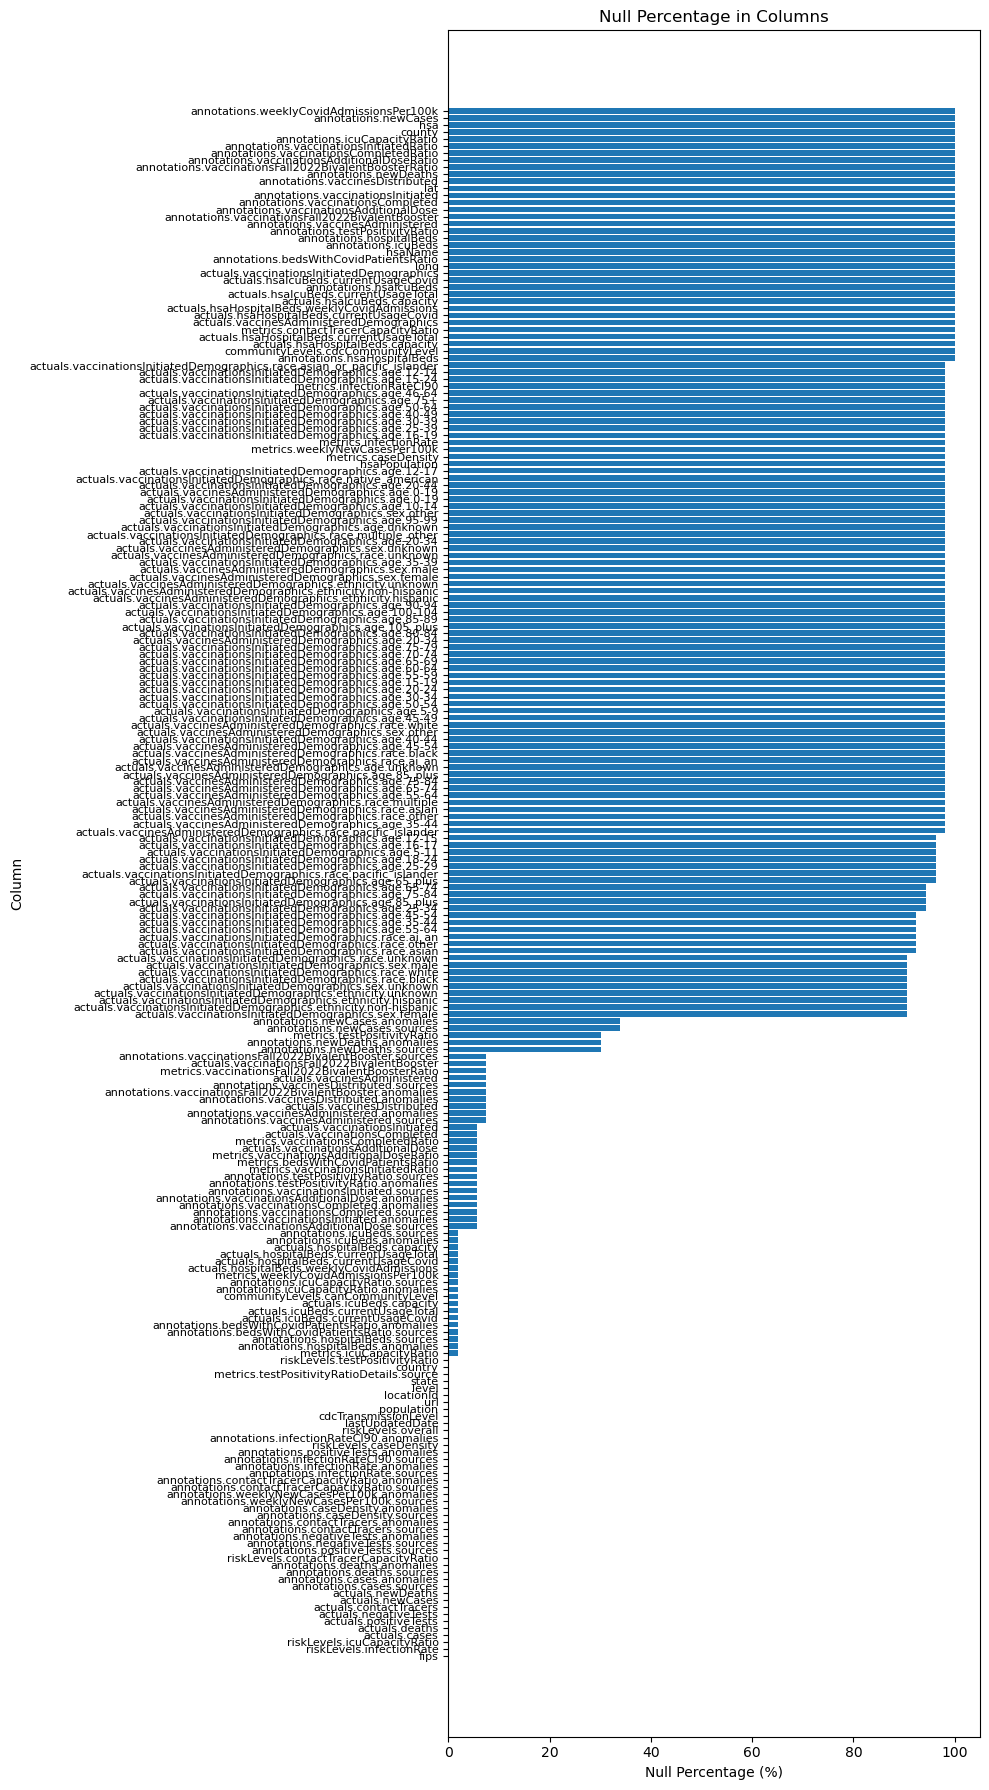

In [8]:
import matplotlib.pyplot as plt

# set the figure size to have larger vertical sizing
plt.figure(figsize=(10, 18))

# create the bar chart from the null table above
plt.barh(sorted_null_percentage_df['Column'], sorted_null_percentage_df['Null Percentage'])

# set labels and title
plt.xlabel('Null Percentage (%)')
plt.ylabel('Column')
plt.title('Null Percentage in Columns')

# make the font size for y-axis labels smaller
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

## Remove fields that are all null

In [9]:
# drop all fields that are 100% null
states.dropna(axis=1, how='all', inplace=True)
states.head()

,fips,country,state,level,locationId,population,hsaPopulation,cdcTransmissionLevel,lastUpdatedDate,url,metrics.testPositivityRatio,metrics.testPositivityRatioDetails.source,metrics.caseDensity,metrics.weeklyNewCasesPer100k,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuCapacityRatio,metrics.bedsWithCovidPatientsRatio,metrics.weeklyCovidAdmissionsPer100k,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,metrics.vaccinationsAdditionalDoseRatio,metrics.vaccinationsFall2022BivalentBoosterRatio,riskLevels.overall,riskLevels.testPositivityRatio,riskLevels.caseDensity,riskLevels.contactTracerCapacityRatio,riskLevels.infectionRate,riskLevels.icuCapacityRatio,communityLevels.canCommunityLevel,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,actuals.hospitalBeds.currentUsageTotal,actuals.hospitalBeds.currentUsageCovid,actuals.hospitalBeds.weeklyCovidAdmissions,actuals.icuBeds.capacity,actuals.icuBeds.currentUsageTotal,actuals.icuBeds.currentUsageCovid,actuals.newCases,actuals.newDeaths,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,actuals.vaccinationsAdditionalDose,actuals.vaccinationsFall2022BivalentBooster,actuals.vaccinesAdministered,annotations.cases.sources,annotations.cases.anomalies,annotations.deaths.sources,annotations.deaths.anomalies,annotations.positiveTests.sources,annotations.positiveTests.anomalies,annotations.negativeTests.sources,annotations.negativeTests.anomalies,annotations.contactTracers.sources,annotations.contactTracers.anomalies,annotations.hospitalBeds.sources,annotations.hospitalBeds.anomalies,annotations.icuBeds.sources,annotations.icuBeds.anomalies,annotations.newCases.sources,annotations.newCases.anomalies,annotations.newDeaths.sources,annotations.newDeaths.anomalies,annotations.vaccinesDistributed.sources,annotations.vaccinesDistributed.anomalies,annotations.vaccinationsInitiated.sources,annotations.vaccinationsInitiated.anomalies,annotations.vaccinationsCompleted.sources,annotations.vaccinationsCompleted.anomalies,annotations.vaccinationsAdditionalDose.sources,annotations.vaccinationsAdditionalDose.anomalies,annotations.vaccinationsFall2022BivalentBooster.sources,annotations.vaccinationsFall2022BivalentBooster.anomalies,annotations.vaccinesAdministered.sources,annotations.vaccinesAdministered.anomalies,annotations.testPositivityRatio.sources,annotations.testPositivityRatio.anomalies,annotations.caseDensity.sources,annotations.caseDensity.anomalies,annotations.weeklyNewCasesPer100k.sources,annotations.weeklyNewCasesPer100k.anomalies,annotations.contactTracerCapacityRatio.sources,annotations.contactTracerCapacityRatio.anomalies,annotations.infectionRate.sources,annotations.infectionRate.anomalies,annotations.infectionRateCI90.sources,annotations.infectionRateCI90.anomalies,annotations.icuCapacityRatio.sources,annotations.icuCapacityRatio.anomalies,annotations.bedsWithCovidPatientsRatio.sources,annotations.bedsWithCovidPatientsRatio.anomalies,actuals.vaccinationsInitiatedDemographics.age.12-15,actuals.vaccinationsInitiatedDemographics.age.16-17,actuals.vaccinationsInitiatedDemographics.age.16-19,actuals.vaccinationsInitiatedDemographics.age.18-24,actuals.vaccinationsInitiatedDemographics.age.20-44,actuals.vaccinationsInitiatedDemographics.age.25-29,actuals.vaccinationsInitiatedDemographics.age.25-34,actuals.vaccinationsInitiatedDemographics.age.25-39,actuals.vaccinationsInitiatedDemographics.age.30-39,actuals.vaccinationsInitiatedDemographics.age.35-44,actuals.vaccinationsInitiatedDemographics.age.40-49,actuals.vaccinationsInitiatedDemographics.age.45-54,actuals.vaccinationsInitiatedDemographics.age.46-64,actuals.vaccinationsInitiatedDemographics.age.5-11,actuals.vaccinationsInitiatedDemographics.age.50-64,actuals.vaccinationsInitiatedDemographics.age.55-64,actuals.vaccinationsInitiatedDemographics.age.65-74,actuals.vaccinationsInitiatedDemographics.age.65_plus

In [10]:
# now only 184 fields
print(states.shape)

(53, 184)


## API call to bring in official name of each state

In [11]:
# make get request to api address
response = requests.get('https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/georef-united-states-of-america-state/records?select=ste_name%2C%20ste_stusps_code&limit=60')

# if succefsully, load in as json, else get the status code
if response.status_code == 200:
    names_json = response.json()
else:
    print(f' failed with status code {response.status_code}')

# print(names_json)

In [12]:
# extract 'results' part
data = names_json['results']

# create a df
names = pd.DataFrame(data)

# since 'ste_name' is a list, extract its first element
names['ste_name'] = names['ste_name'].apply(lambda x: x[0])

names.head()

,ste_name,ste_stusps_code
0,Rhode Island,RI
1,Georgia,GA
2,North Dakota,ND
3,Louisiana,LA
4,Alaska,AK


## join states with names to get states with names

In [13]:
states_with_names = pd.merge(names, states, left_on='ste_stusps_code', right_on='state')
states_with_names.head()

,ste_name,ste_stusps_code,fips,country,state,level,locationId,population,hsaPopulation,cdcTransmissionLevel,lastUpdatedDate,url,metrics.testPositivityRatio,metrics.testPositivityRatioDetails.source,metrics.caseDensity,metrics.weeklyNewCasesPer100k,metrics.infectionRate,metrics.infectionRateCI90,metrics.icuCapacityRatio,metrics.bedsWithCovidPatientsRatio,metrics.weeklyCovidAdmissionsPer100k,metrics.vaccinationsInitiatedRatio,metrics.vaccinationsCompletedRatio,metrics.vaccinationsAdditionalDoseRatio,metrics.vaccinationsFall2022BivalentBoosterRatio,riskLevels.overall,riskLevels.testPositivityRatio,riskLevels.caseDensity,riskLevels.contactTracerCapacityRatio,riskLevels.infectionRate,riskLevels.icuCapacityRatio,communityLevels.canCommunityLevel,actuals.cases,actuals.deaths,actuals.positiveTests,actuals.negativeTests,actuals.contactTracers,actuals.hospitalBeds.capacity,actuals.hospitalBeds.currentUsageTotal,actuals.hospitalBeds.currentUsageCovid,actuals.hospitalBeds.weeklyCovidAdmissions,actuals.icuBeds.capacity,actuals.icuBeds.currentUsageTotal,actuals.icuBeds.currentUsageCovid,actuals.newCases,actuals.newDeaths,actuals.vaccinesDistributed,actuals.vaccinationsInitiated,actuals.vaccinationsCompleted,actuals.vaccinationsAdditionalDose,actuals.vaccinationsFall2022BivalentBooster,actuals.vaccinesAdministered,annotations.cases.sources,annotations.cases.anomalies,annotations.deaths.sources,annotations.deaths.anomalies,annotations.positiveTests.sources,annotations.positiveTests.anomalies,annotations.negativeTests.sources,annotations.negativeTests.anomalies,annotations.contactTracers.sources,annotations.contactTracers.anomalies,annotations.hospitalBeds.sources,annotations.hospitalBeds.anomalies,annotations.icuBeds.sources,annotations.icuBeds.anomalies,annotations.newCases.sources,annotations.newCases.anomalies,annotations.newDeaths.sources,annotations.newDeaths.anomalies,annotations.vaccinesDistributed.sources,annotations.vaccinesDistributed.anomalies,annotations.vaccinationsInitiated.sources,annotations.vaccinationsInitiated.anomalies,annotations.vaccinationsCompleted.sources,annotations.vaccinationsCompleted.anomalies,annotations.vaccinationsAdditionalDose.sources,annotations.vaccinationsAdditionalDose.anomalies,annotations.vaccinationsFall2022BivalentBooster.sources,annotations.vaccinationsFall2022BivalentBooster.anomalies,annotations.vaccinesAdministered.sources,annotations.vaccinesAdministered.anomalies,annotations.testPositivityRatio.sources,annotations.testPositivityRatio.anomalies,annotations.caseDensity.sources,annotations.caseDensity.anomalies,annotations.weeklyNewCasesPer100k.sources,annotations.weeklyNewCasesPer100k.anomalies,annotations.contactTracerCapacityRatio.sources,annotations.contactTracerCapacityRatio.anomalies,annotations.infectionRate.sources,annotations.infectionRate.anomalies,annotations.infectionRateCI90.sources,annotations.infectionRateCI90.anomalies,annotations.icuCapacityRatio.sources,annotations.icuCapacityRatio.anomalies,annotations.bedsWithCovidPatientsRatio.sources,annotations.bedsWithCovidPatientsRatio.anomalies,actuals.vaccinationsInitiatedDemographics.age.12-15,actuals.vaccinationsInitiatedDemographics.age.16-17,actuals.vaccinationsInitiatedDemographics.age.16-19,actuals.vaccinationsInitiatedDemographics.age.18-24,actuals.vaccinationsInitiatedDemographics.age.20-44,actuals.vaccinationsInitiatedDemographics.age.25-29,actuals.vaccinationsInitiatedDemographics.age.25-34,actuals.vaccinationsInitiatedDemographics.age.25-39,actuals.vaccinationsInitiatedDemographics.age.30-39,actuals.vaccinationsInitiatedDemographics.age.35-44,actuals.vaccinationsInitiatedDemographics.age.40-49,actuals.vaccinationsInitiatedDemographics.age.45-54,actuals.vaccinationsInitiatedDemographics.age.46-64,actuals.vaccinationsInitiatedDemographics.age.5-11,actuals.vaccinationsInitiatedDemographics.age.50-64,actuals.vaccinationsInitiatedDemographics.age.55-64,actuals.vaccinationsInitiatedDemographics.age.65-74,actuals.vaccinationsInitiate

# Part 2

Pull values from API & convert the data into a data frame using pandas.

In [14]:
import pandas as pd
import requests

# Define API URL
api_url = "https://data.cdc.gov/resource/unsk-b7fc.json"

# Fetch data from API
response = requests.get(api_url)

# Verify if the request was successful
if response.status_code == 200:
    data = response.json()  # Convert response to JSON
    df = pd.DataFrame(data)  # Convert JSON data to DataFrame
    print("Successfully retrieved data from the API")
else:
    print("Failed to retrieve data from the API")

Successfully retrieved data from the API


Get familiar with the data type

In [15]:
# Display every column & corresponding datatype
print('Data Types:')
for column in df.columns:
    print(f"{column}: {df[column].dtype}")

Data Types:
date: object
mmwr_week: object
location: object
distributed: object
distributed_janssen: object
distributed_moderna: object
distributed_pfizer: object
distributed_novavax: object
distributed_unk_manuf: object
dist_per_100k: object
distributed_per_100k_5plus: object
distributed_per_100k_12plus: object
distributed_per_100k_18plus: object
distributed_per_100k_65plus: object
administered: object
administered_5plus: object
administered_12plus: object
administered_18plus: object
administered_65plus: object
administered_janssen: object
administered_moderna: object
administered_pfizer: object
administered_novavax: object
administered_unk_manuf: object
admin_per_100k: object
admin_per_100k_5plus: object
admin_per_100k_12plus: object
admin_per_100k_18plus: object
admin_per_100k_65plus: object
recip_administered: object
administered_dose1_recip: object
administered_dose1_pop_pct: object
administered_dose1_recip_5plus: object
administered_dose1_recip_5pluspop_pct: object
administered_d

As many of the columns are structured in an object data type, I have converted them into suitable data types for further analysis

In [16]:
# Convert 'date' to datetime datatype
df['date'] = pd.to_datetime(df['date'])

# Define columns to convert to numeric datatype
numeric_columns = df.columns.drop(['date', 'location'])

# Convert numeric columns to numeric datatype
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Combine numeric & non-numeric columns
combined_df = pd.concat([df[['date', 'location']], df.drop(columns=['date', 'location'])], axis=1)

# Verify the data types after conversion & combination
print('Data Types:')
for column in combined_df.columns:
    print(f"{column}: {combined_df[column].dtype}")

Data Types:
date: datetime64[ns]
location: object
mmwr_week: int64
distributed: int64
distributed_janssen: int64
distributed_moderna: int64
distributed_pfizer: int64
distributed_novavax: int64
distributed_unk_manuf: int64
dist_per_100k: int64
distributed_per_100k_5plus: int64
distributed_per_100k_12plus: int64
distributed_per_100k_18plus: int64
distributed_per_100k_65plus: int64
administered: int64
administered_5plus: int64
administered_12plus: int64
administered_18plus: int64
administered_65plus: int64
administered_janssen: int64
administered_moderna: int64
administered_pfizer: int64
administered_novavax: int64
administered_unk_manuf: int64
admin_per_100k: int64
admin_per_100k_5plus: int64
admin_per_100k_12plus: int64
admin_per_100k_18plus: int64
admin_per_100k_65plus: int64
recip_administered: int64
administered_dose1_recip: int64
administered_dose1_pop_pct: float64
administered_dose1_recip_5plus: int64
administered_dose1_recip_5pluspop_pct: float64
administered_dose1_recip_12plus: i

Detect & identify null values

In [17]:
# Display null values in each column
print("Null Values in Each Column:")
for column in combined_df.columns:
    null_count = combined_df[column].isnull().sum()
    print(f"{column}: {null_count} null values")

Null Values in Each Column:
date: 0 null values
location: 0 null values
mmwr_week: 0 null values
distributed: 0 null values
distributed_janssen: 0 null values
distributed_moderna: 0 null values
distributed_pfizer: 0 null values
distributed_novavax: 0 null values
distributed_unk_manuf: 0 null values
dist_per_100k: 0 null values
distributed_per_100k_5plus: 0 null values
distributed_per_100k_12plus: 0 null values
distributed_per_100k_18plus: 0 null values
distributed_per_100k_65plus: 0 null values
administered: 0 null values
administered_5plus: 0 null values
administered_12plus: 0 null values
administered_18plus: 0 null values
administered_65plus: 0 null values
administered_janssen: 0 null values
administered_moderna: 0 null values
administered_pfizer: 0 null values
administered_novavax: 0 null values
administered_unk_manuf: 0 null values
admin_per_100k: 0 null values
admin_per_100k_5plus: 0 null values
admin_per_100k_12plus: 0 null values
admin_per_100k_18plus: 0 null values
admin_per_10

The previous code makes it apparent that not all participants received a second booster resulting in 984 null values

In [18]:
# Identify what locations are included in the dataset and how they're coded
distinct_locations = df['location'].unique()
print('\n Locations in dataset')
print(distinct_locations)

# Total locations
print('\n Total unique locations')
print(df['location'].nunique())


 Locations in dataset
['NE' 'LA' 'GA' 'WY' 'CO' 'PA' 'DE' 'OR' 'WI' 'ND' 'TX' 'MN' 'UT' 'SC'
 'DC' 'NC' 'WA' 'SD' 'PR' 'RI' 'IA' 'FM' 'PW' 'NV' 'KY' 'VI' 'WV' 'VA2'
 'ME' 'ID' 'BP2' 'MP' 'US' 'IH2' 'MS' 'IL' 'KS' 'MH' 'FL' 'MO' 'GU' 'VT'
 'CT' 'OH' 'NJ' 'DD2' 'TN' 'CA' 'MT' 'IN' 'NY' 'AL' 'VA' 'MD' 'AR' 'HI'
 'OK' 'NH' 'AZ' 'MI' 'AS' 'AK' 'MA' 'NM']

 Total unique locations
64


As state is a primary connection between the datasets, I wanted to see similarities and differences

In [19]:
# Get unique state abbreviations from distinct_states
state_abbreviations = [state[:2] for state in distinct_states]

# Compare state abbreviations with distinct locations
similar_locations = set(state_abbreviations) & set(distinct_locations)
different_locations = set(distinct_locations) - set(state_abbreviations)

# Print results
print("Similar locations:", similar_locations)
print("Different locations:", different_locations)

Similar locations: {'PR', 'KS', 'UT', 'TX', 'HI', 'MS', 'MD', 'FL', 'PA', 'RI', 'NE', 'MP', 'OH', 'VA', 'MT', 'ME', 'CT', 'ND', 'CA', 'NY', 'TN', 'GA', 'AL', 'MO', 'OR', 'ID', 'DC', 'OK', 'AK', 'MI', 'CO', 'AR', 'DE', 'IN', 'KY', 'MA', 'LA', 'WA', 'WY', 'IA', 'WI', 'VT', 'SC', 'NC', 'IL', 'NV', 'SD', 'MN', 'AZ', 'WV', 'NJ', 'NH', 'NM'}
Different locations: {'US', 'MH', 'DD2', 'PW', 'VI', 'AS', 'FM', 'BP2', 'VA2', 'GU', 'IH2'}


Wehn reviewing the different locations, here is what I believe the abbreviations are indicative of:

* 'VI': Virgin Islands
* 'US': United States
* 'VA2': Virginia
* 'FM': Federated States of Micronesia
* 'GU': Guam
* 'MH': Marshall Islands
* 'PW': Palau
* 'AS': American Samoa

I was not too certain on the location of the following:
* 'BP2'
* 'DD2'
* 'IH2'

To ensure compatibility, those values will be excluded from this study.

In [20]:
# Indicate locations to drop
excluded_locations = ['VI', 'US', 'VA2', 'BP2', 'FM', 'GU', 'MH', 'PW', 'DD2', 'IH2', 'AS']

# Filter out rows where location is not in excluded_locations
filtered_df = combined_df[~combined_df['location'].isin(excluded_locations)]

In [21]:
# Display dimensions of remaining values
filtered_df.shape

(829, 109)

To facilitate EDA, subsets were created comprising of distributed, administered, series complete, additional doses, second boosters, and bivalent booster

In [22]:
# Make a copy of the original DataFrame
filtered_df_copy = filtered_df.copy()

# Add a 'index' column to the copied DataFrame with 4-digit index starting from 1000
filtered_df_copy['index'] = range(1000, 1000 + len(filtered_df_copy))

# Convert the index to a 4-digit string
filtered_df_copy['index'] = filtered_df_copy['index'].map(lambda x: f'{x:04d}')


# Define column mappings
column_mappings = {
    'distributed': [
        'index', 'date', 'mmwr_week', 'location', 'distributed', 'distributed_janssen',
        'distributed_moderna', 'distributed_pfizer', 'distributed_novavax',
        'distributed_unk_manuf', 'dist_per_100k', 'distributed_per_100k_5plus',
        'distributed_per_100k_12plus', 'distributed_per_100k_18plus',
        'distributed_per_100k_65plus'
    ],
    'administered': [
        'index', 'date', 'mmwr_week', 'location', 'administered', 'administered_5plus',
        'administered_12plus', 'administered_18plus', 'administered_65plus',
        'administered_janssen', 'administered_moderna', 'administered_pfizer',
        'administered_novavax', 'administered_unk_manuf', 'admin_per_100k',
        'admin_per_100k_5plus', 'admin_per_100k_12plus', 'admin_per_100k_18plus',
        'admin_per_100k_65plus', 'recip_administered', 'administered_dose1_recip',
        'administered_dose1_pop_pct', 'administered_dose1_recip_5plus',
        'administered_dose1_recip_5pluspop_pct', 'administered_dose1_recip_12plus',
        'administered_dose1_recip_12pluspop_pct', 'administered_dose1_recip_18plus',
        'administered_dose1_recip_18pluspop_pct', 'administered_dose1_recip_65plus',
        'administered_dose1_recip_65pluspop_pct'
    ],
    'series_complete': [
        'index', 'date', 'location', 'series_complete_yes', 'series_complete_pop_pct', 'series_complete_5plus',
        'series_complete_5pluspop_pct', 'series_complete_12plus', 'series_complete_12pluspop',
        'series_complete_18plus', 'series_complete_18pluspop', 'series_complete_65plus',
        'series_complete_65pluspop', 'series_complete_janssen', 'series_complete_moderna',
        'series_complete_pfizer', 'series_complete_novavax', 'series_complete_unk_manuf',
        'series_complete_janssen_5plus', 'series_complete_moderna_5plus',
        'series_complete_pfizer_5plus', 'series_complete_unk_manuf_5plus',
        'series_complete_janssen_12plus', 'series_complete_moderna_12plus',
        'series_complete_pfizer_12plus', 'series_complete_unk_manuf_1',
        'series_complete_janssen_18plus', 'series_complete_moderna_18plus',
        'series_complete_pfizer_18plus', 'series_complete_unk_manuf_2',
        'series_complete_janssen_65plus', 'series_complete_moderna_65plus',
        'series_complete_pfizer_65plus', 'series_complete_unk_manuf_3'
    ],
    'additional_doses': [
        'index', 'date', 'location', 'additional_doses', 'additional_doses_vax_pct', 'additional_doses_5plus',
        'additional_doses_5plus_vax_pct', 'additional_doses_12plus',
        'additional_doses_12plus_vax_pct', 'additional_doses_18plus',
        'additional_doses_18plus_vax_pct', 'additional_doses_50plus',
        'additional_doses_50plus_vax_pct', 'additional_doses_65plus',
        'additional_doses_65plus_vax_pct', 'additional_doses_moderna',
        'additional_doses_pfizer', 'additional_doses_janssen',
        'additional_doses_unk_manuf'
    ],
    'second_booster': [
        'index', 'date', 'location', 'second_booster', 'second_booster_50plus', 'second_booster_50plus_vax_pct',
        'second_booster_65plus', 'second_booster_65plus_vax_pct',
        'second_booster_janssen', 'second_booster_moderna', 'second_booster_pfizer',
        'second_booster_unk_manuf'
    ],
    'bivalent_booster': [
        'index', 'date', 'location', 'administered_bivalent', 'admin_bivalent_pfr', 'admin_bivalent_mod',
        'dist_bivalent_pfr', 'dist_bivalent_mod', 'bivalent_booster_5plus',
        'bivalent_booster_5plus_pop_pct', 'bivalent_booster_12plus',
        'bivalent_booster_12plus_pop_pct', 'bivalent_booster_18plus',
        'bivalent_booster_18plus_pop_pct', 'bivalent_booster_65plus',
        'bivalent_booster_65plus_pop_pct'
    ]
}

# Create separate DataFrames from the copied DataFrame
distributed_df = filtered_df_copy[column_mappings['distributed']].copy()
administered_df = filtered_df_copy[column_mappings['administered']].copy()
series_complete_df = filtered_df_copy[column_mappings['series_complete']].copy()
additional_doses_df = filtered_df_copy[column_mappings['additional_doses']].copy()
second_booster_df = filtered_df_copy[column_mappings['second_booster']].copy()
bivalent_booster_df = filtered_df_copy[column_mappings['bivalent_booster']].copy()

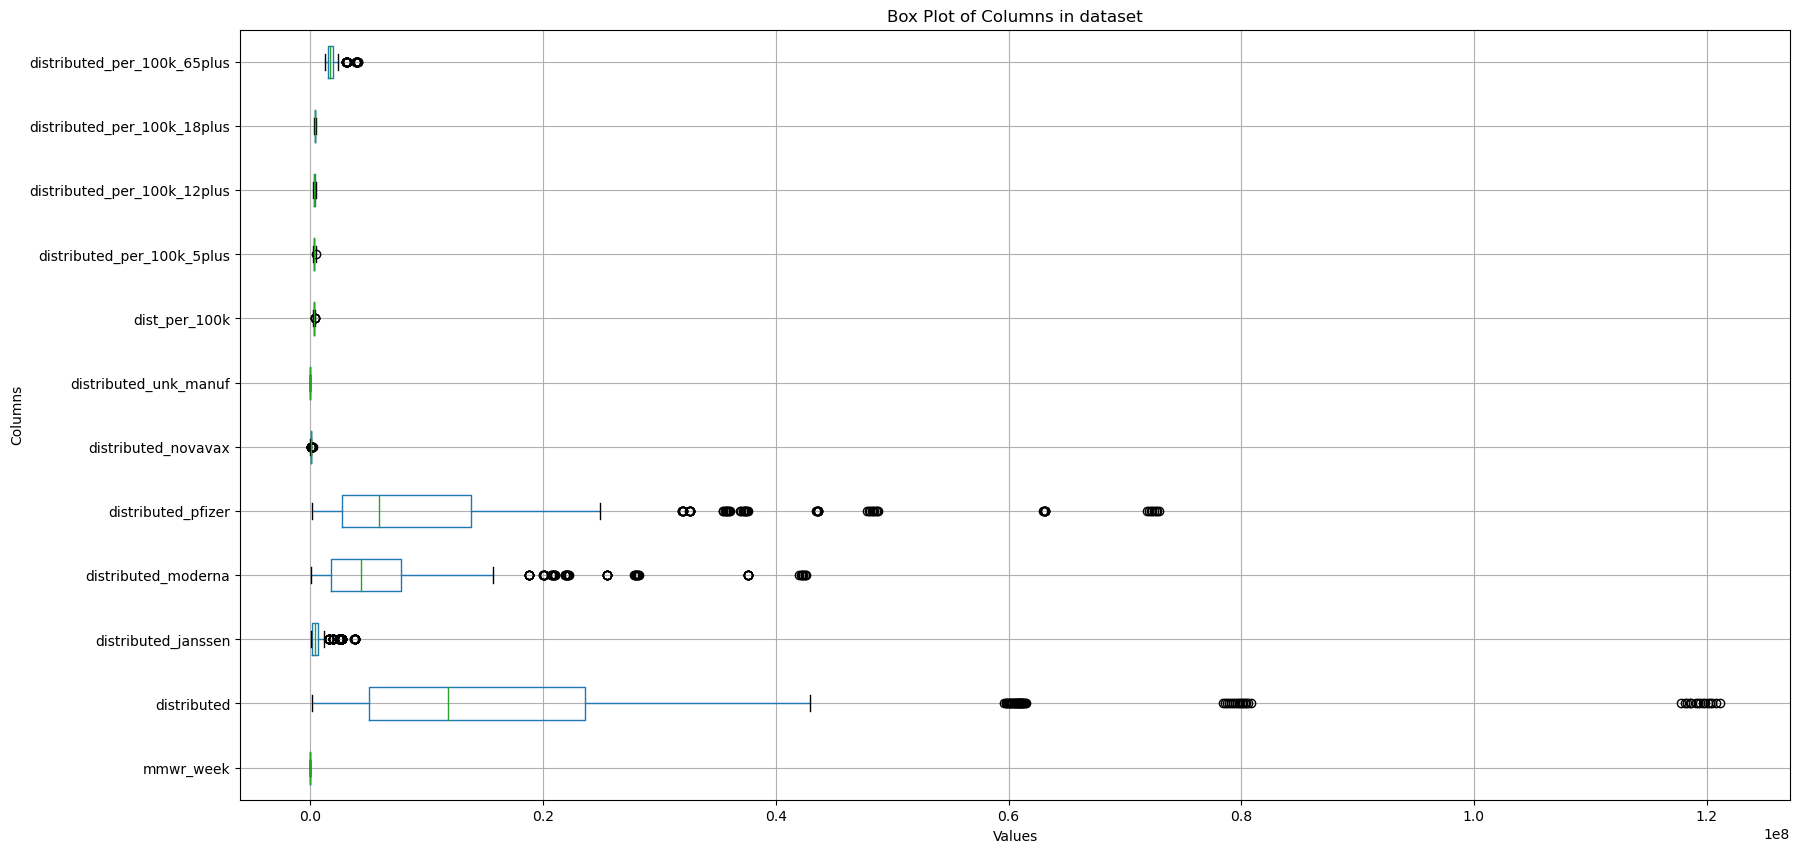

In [23]:
import matplotlib.pyplot as plt

# Define fx for boxplot
def plot_boxplot(dataset):
    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(20, 10))
    # Generate box plots for each column in the dataset
    dataset.boxplot(ax=ax, vert=False)
    # Set the title and labels
    plt.title('Box Plot of Columns in dataset')
    plt.xlabel('Values')
    plt.ylabel('Columns')
    # Show the plot
    plt.show()

# Plot distributed_df
plot_boxplot(distributed_df)

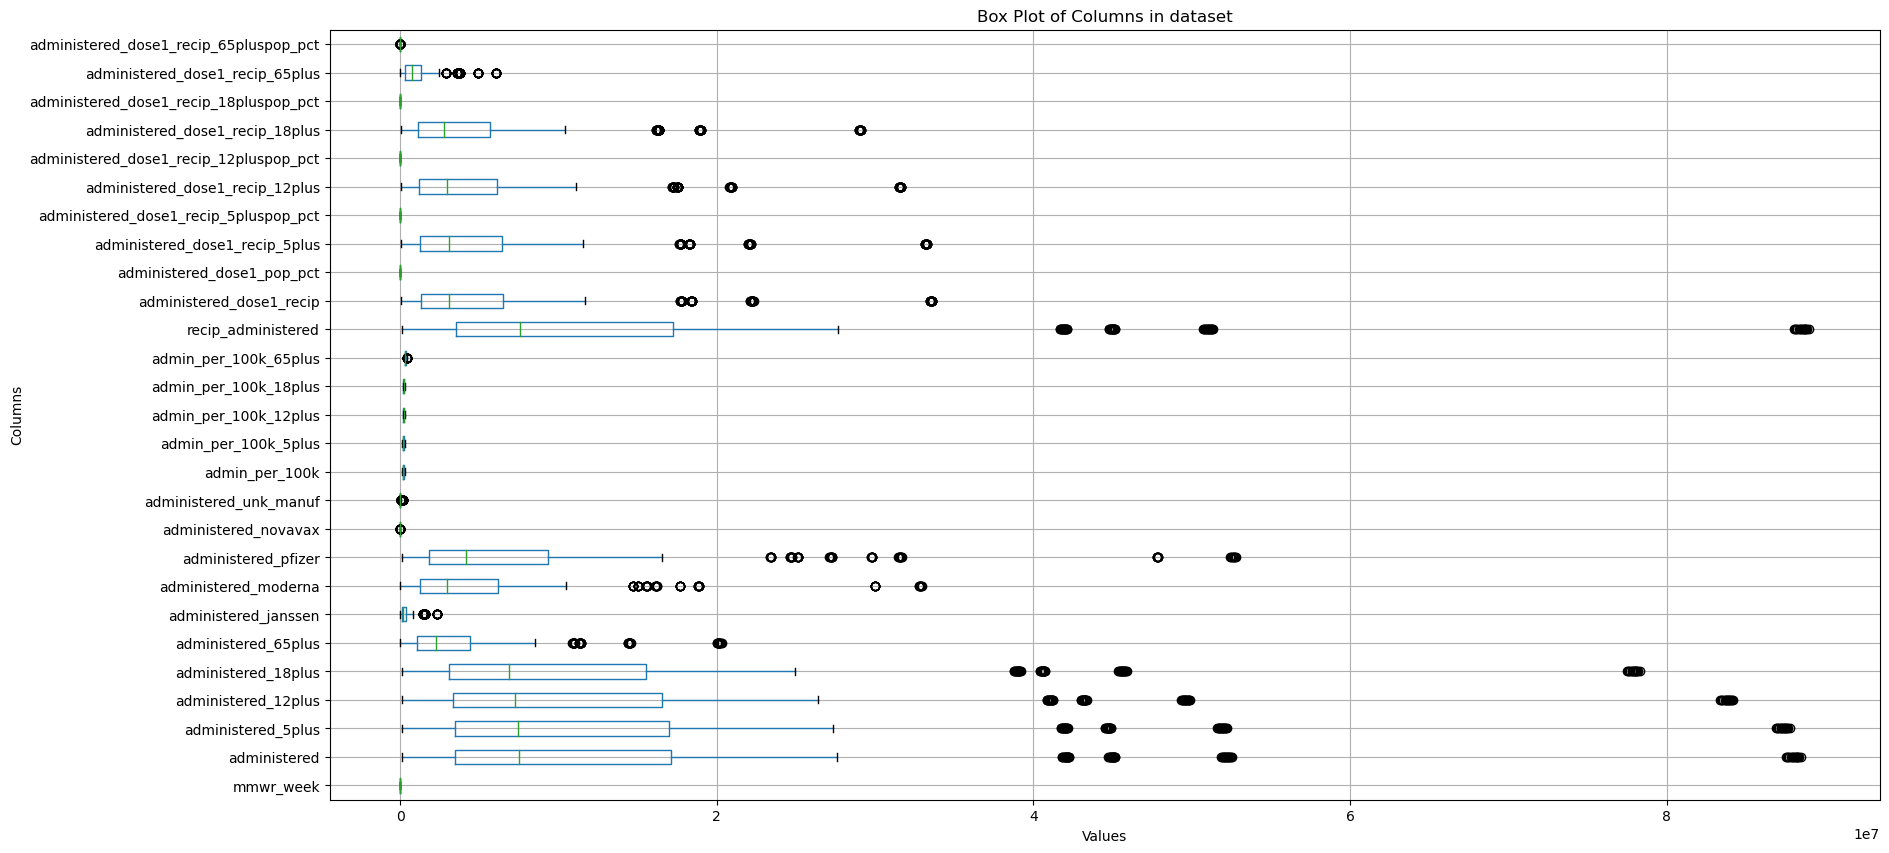

In [24]:
# Plot administered_df
plot_boxplot(administered_df)

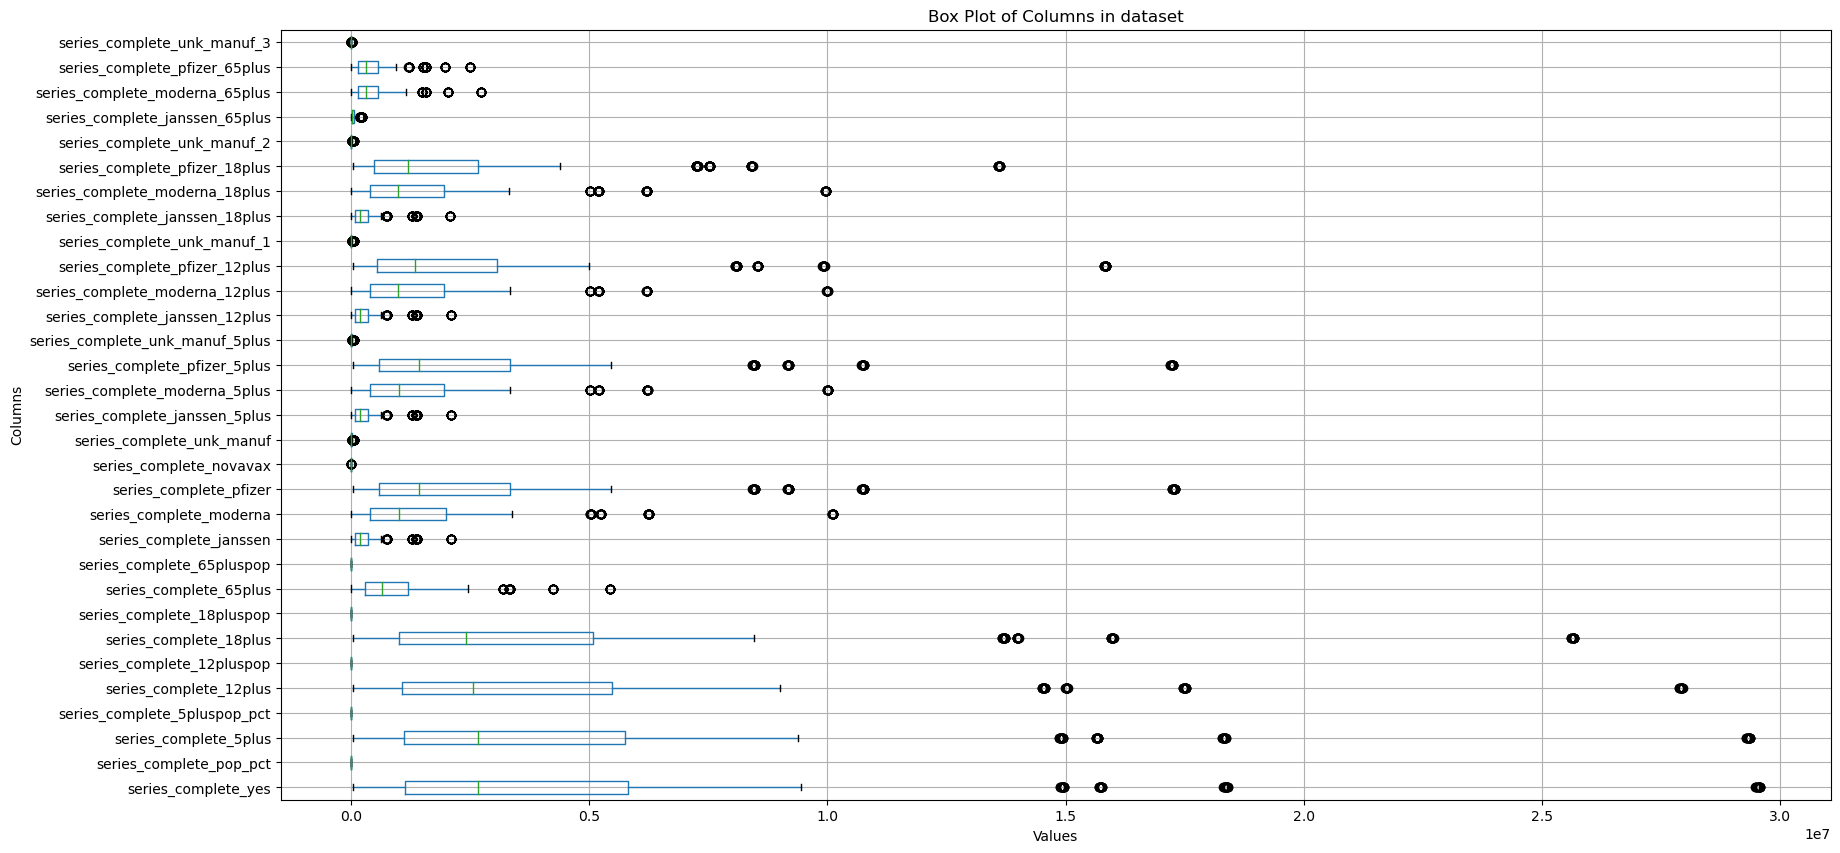

In [25]:
# Plot series_complete_df
plot_boxplot(series_complete_df)

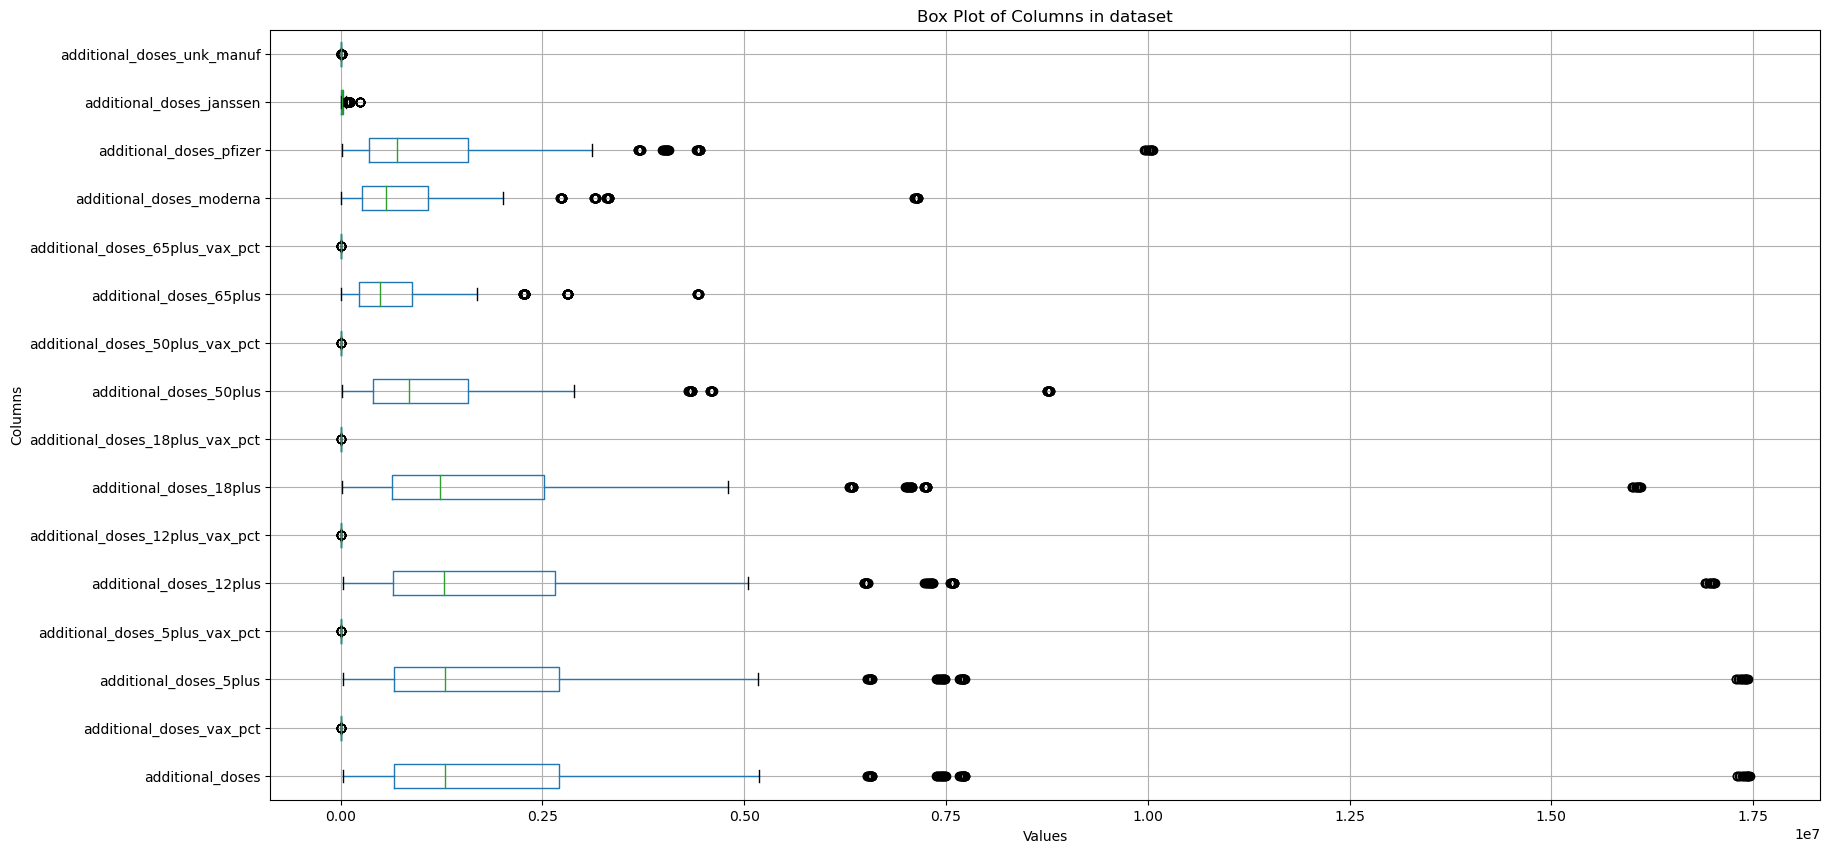

In [26]:
# Plot additional_doses_df
plot_boxplot(additional_doses_df)

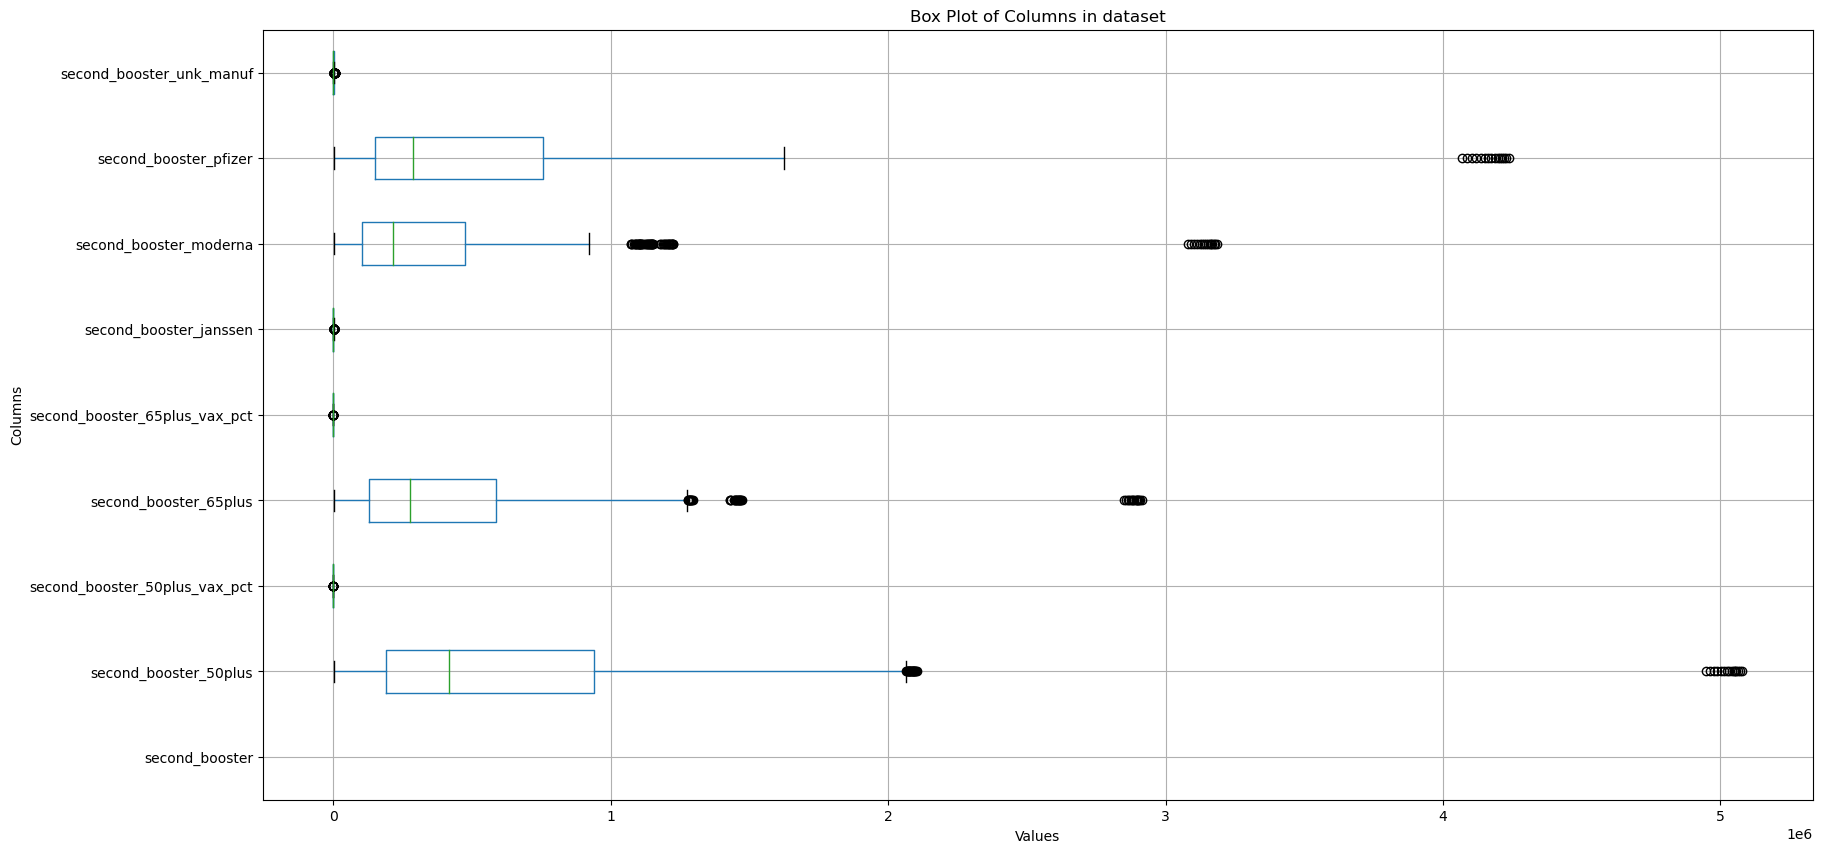

In [27]:
# Plot second_booster_df
plot_boxplot(second_booster_df)

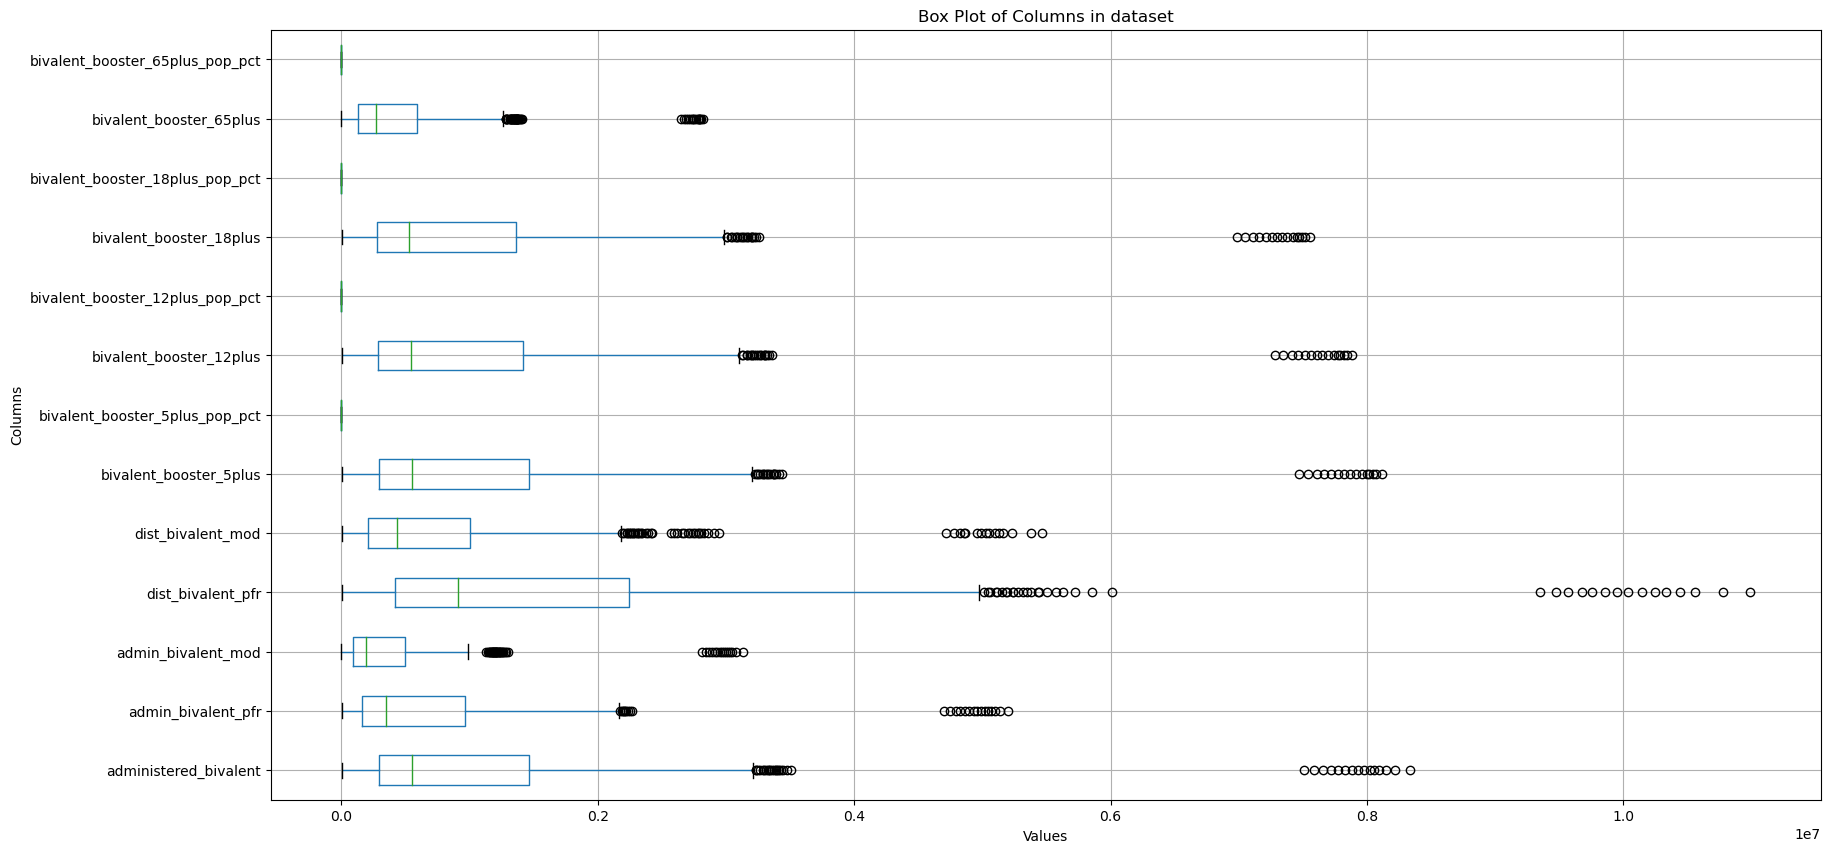

In [28]:
# Plot bivalent_booster_df
plot_boxplot(bivalent_booster_df)

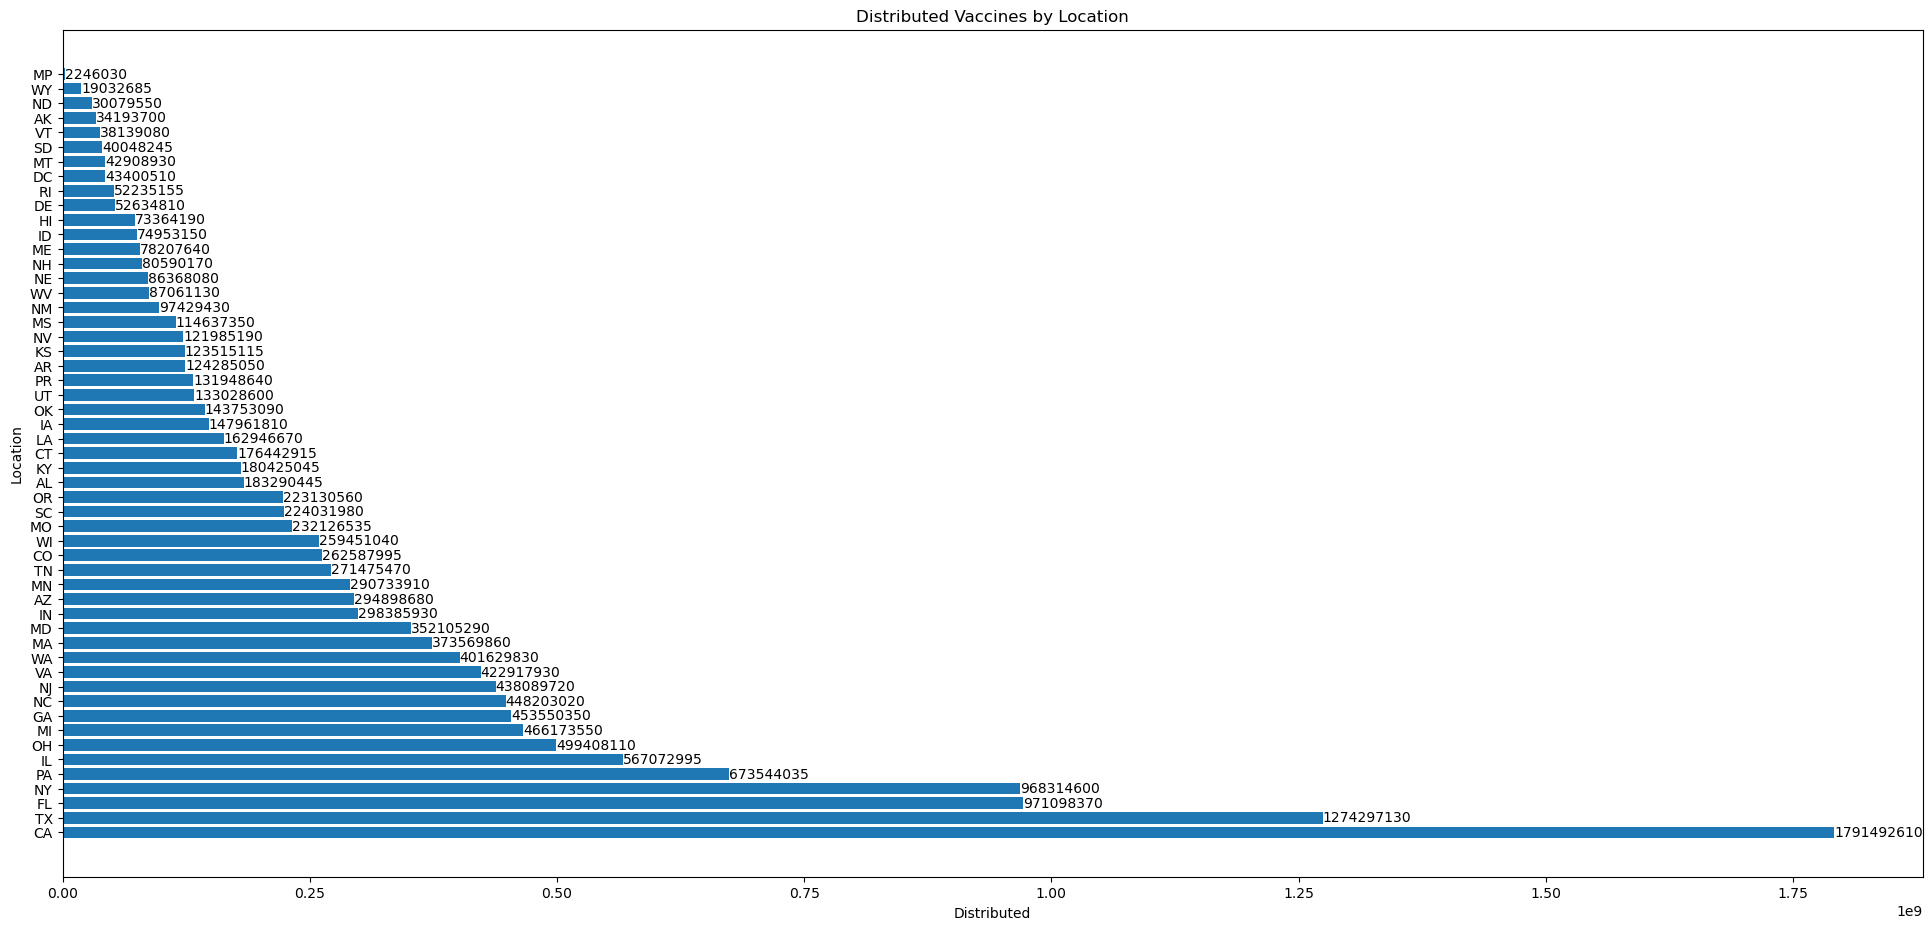

In [29]:
# Group the data by location and sum the distributed values
grouped_data = filtered_df.groupby('location')['distributed'].sum().sort_values(ascending=False)

# Set the figure size
plt.figure(figsize=(24, 11))

# Create a horizontal bar chart
plt.barh(grouped_data.index, grouped_data.values)

# Annotate each bar w/ the total sum value
for i, value in enumerate(grouped_data.values):
    plt.text(value, i, str(value), ha='left', va='center')

plt.xlabel('Distributed')
plt.ylabel('Location')
plt.title('Distributed Vaccines by Location')
plt.show()

<Figure size 2400x1100 with 0 Axes>

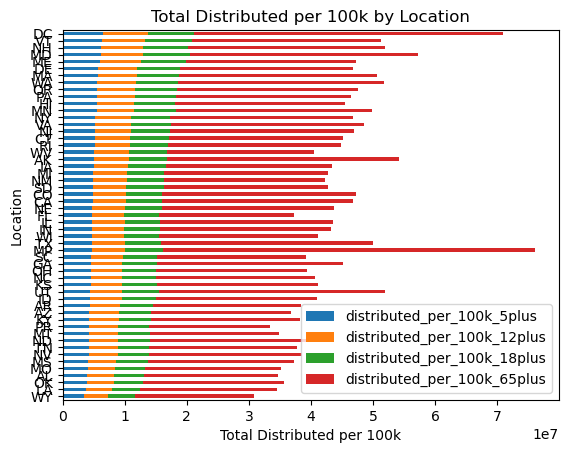

In [30]:
# Group the data by location and sum the specified columns
stacked_data = filtered_df.groupby('location')[['distributed_per_100k_5plus',
                                                'distributed_per_100k_12plus',
                                                'distributed_per_100k_18plus',
                                                'distributed_per_100k_65plus']].sum()

# Sort the data by total sum in descending order
stacked_data['total_sum'] = stacked_data.sum(axis=1)
stacked_data = stacked_data.sort_values(by='total_sum', ascending=False)

# Drop the 'total_sum' column after sorting
stacked_data.drop(columns=['total_sum'], inplace=True)

# Set the figure size
plt.figure(figsize=(24, 11))

# Plot horizontal stacked bar chart
stacked_data.sort_values(by='distributed_per_100k_5plus', ascending=True).plot(kind='barh', stacked=True)

plt.xlabel('Total Distributed per 100k')
plt.ylabel('Location')
plt.title('Total Distributed per 100k by Location')

plt.show()

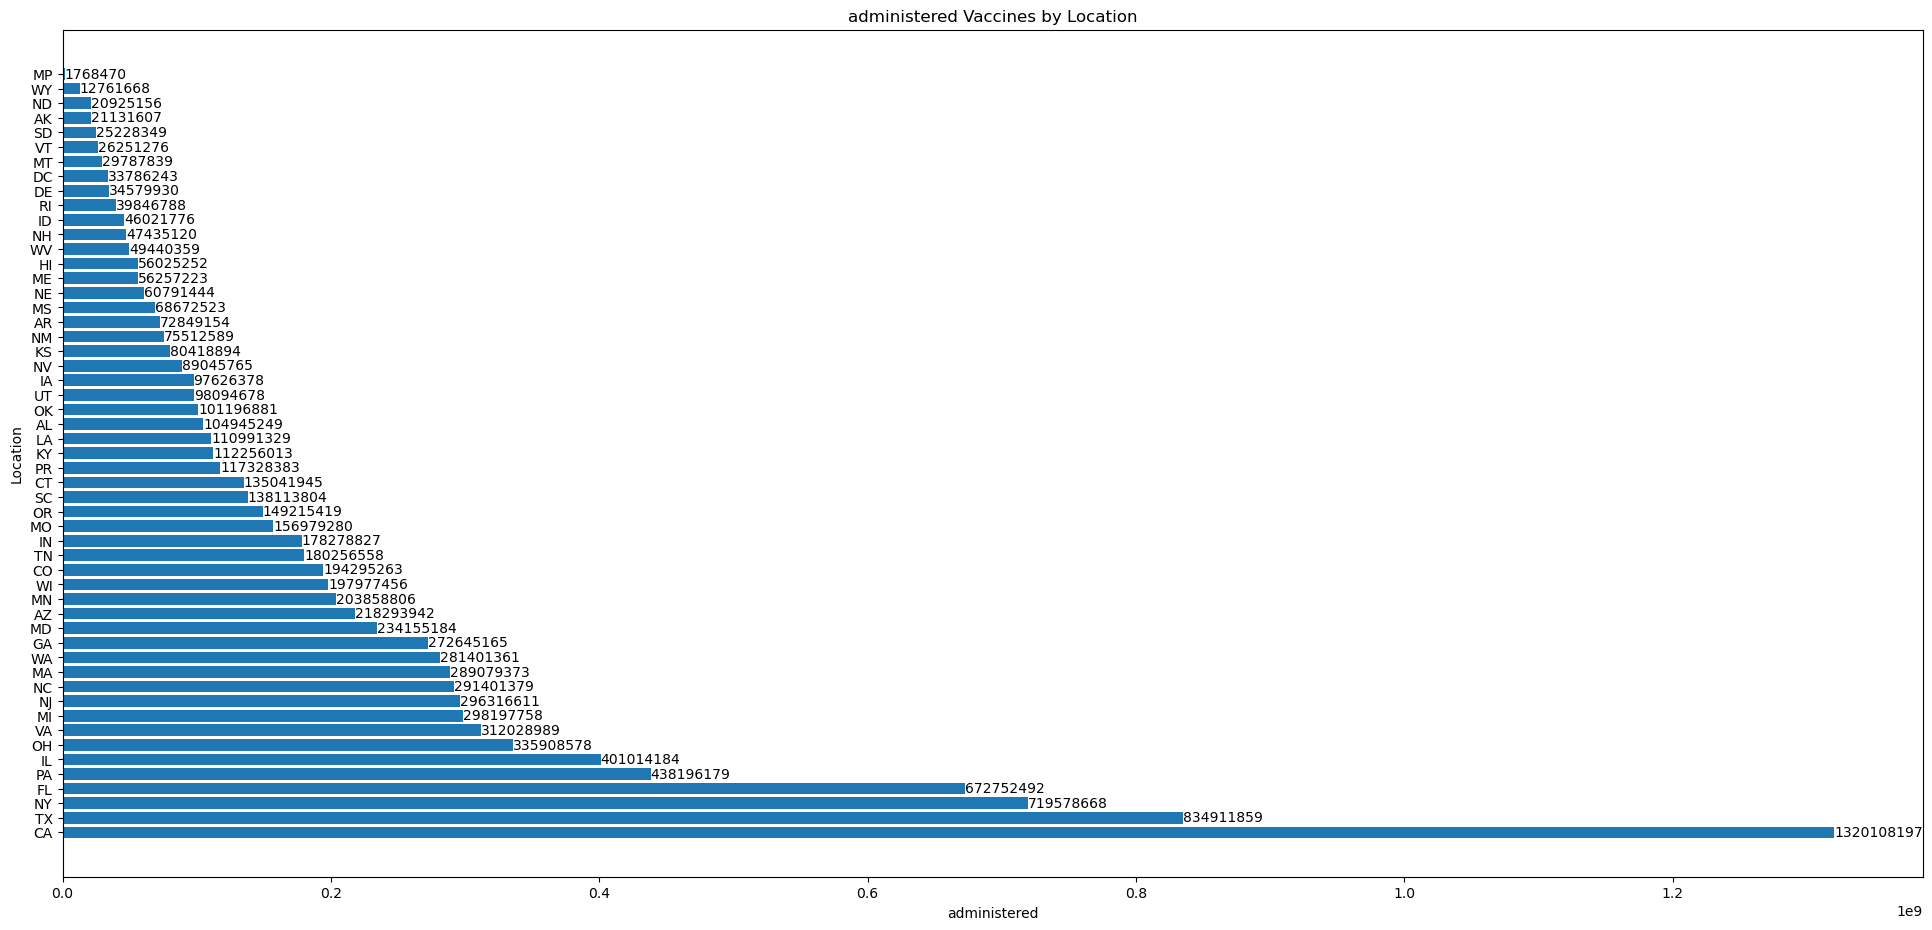

In [31]:
# Group by location & sum the administered values
grouped_data = filtered_df.groupby('location')['administered'].sum().sort_values(ascending=False)

# Set figure size
plt.figure(figsize=(24, 11))

# Create horizontal bar chart
plt.barh(grouped_data.index, grouped_data.values)

# Annotate each bar w/ the total sum value
for i, value in enumerate(grouped_data.values):
    plt.text(value, i, str(value), ha='left', va='center')

plt.xlabel('administered')
plt.ylabel('Location')
plt.title('administered Vaccines by Location')
plt.show()

<Figure size 2400x2400 with 0 Axes>

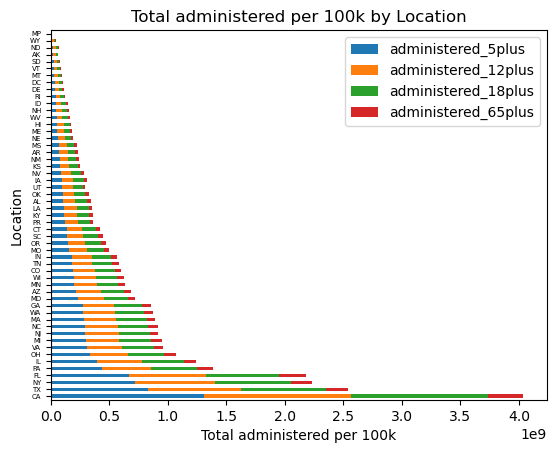

In [32]:
# Group the data by location and sum the specified columns
stacked_data = filtered_df.groupby('location')[['administered_5plus',
                                                'administered_12plus',
                                                'administered_18plus',
                                                'administered_65plus']].sum()

# Sort the data by total sum in descending order
stacked_data['total_sum'] = stacked_data.sum(axis=1)
stacked_data = stacked_data.sort_values(by='total_sum', ascending=False)

# Drop the 'total_sum' column after sorting
stacked_data.drop(columns=['total_sum'], inplace=True)

# Set the figure size
plt.figure(figsize=(24, 24))

# Plot horizontal stacked bar chart
stacked_data.sort_values(by='administered_5plus', ascending=False).plot(kind='barh', stacked=True)

plt.xlabel('Total administered per 100k')
plt.ylabel('Location')
plt.title('Total administered per 100k by Location')

# Adjust spacing between y-axis labels
plt.yticks(fontsize= 5)

plt.show()

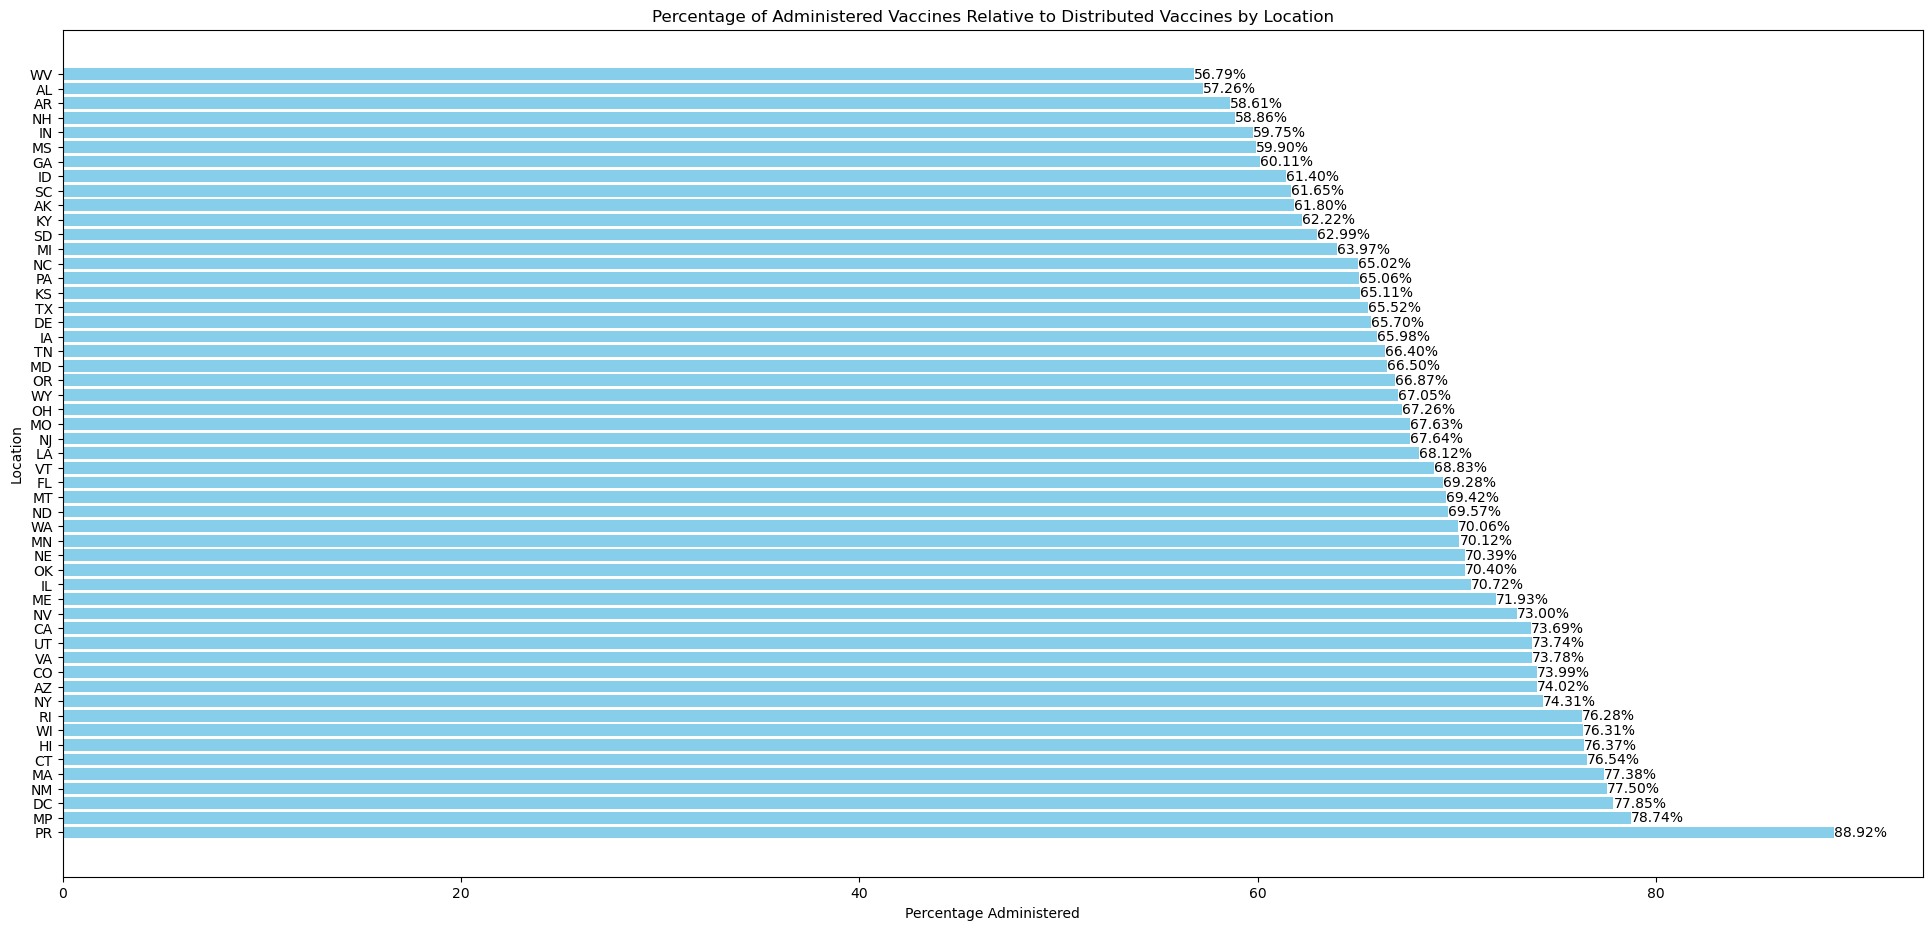

In [33]:
# Group by location & sum administered/distributed values
grouped_data = filtered_df.groupby('location')[['administered', 'distributed']].sum()

# Calculate percentage of administered vaccines relative to distributed
grouped_data['administered_percentage'] = grouped_data['administered'] / grouped_data['distributed'] * 100

# Sort in desc order
grouped_data_sorted = grouped_data['administered_percentage'].sort_values(ascending=False)

# Set figure size
plt.figure(figsize=(24, 11))

# Create horizontal bar chart
plt.barh(grouped_data_sorted.index, grouped_data_sorted.values, color='skyblue')

# Annotate each bar with the percentage value
for i, value in enumerate(grouped_data_sorted.values):
    plt.text(value, i, f'{value:.2f}%', ha='left', va='center')

plt.xlabel('Percentage Administered')
plt.ylabel('Location')
plt.title('Percentage of Administered Vaccines Relative to Distributed Vaccines by Location')
plt.show()

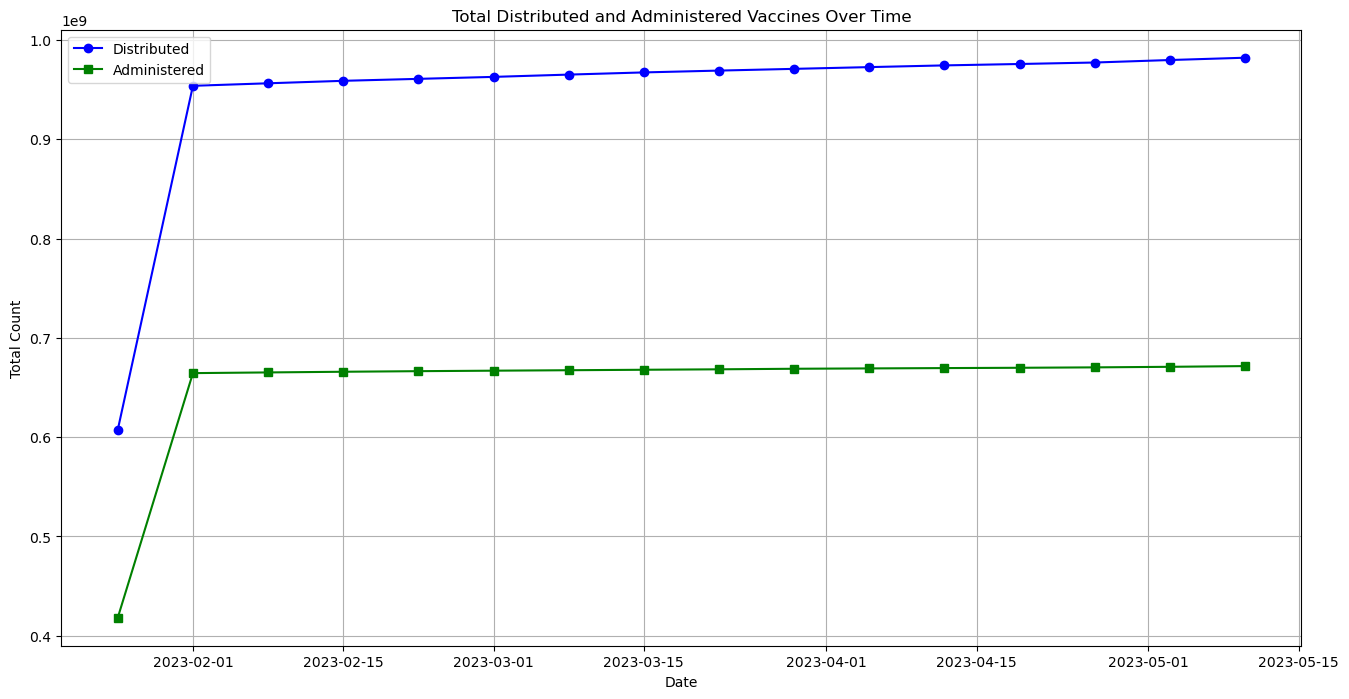

In [34]:
# Group by date and sum the distributed and administered values
grouped_data = filtered_df.groupby('date')[['distributed', 'administered']].sum()

# Plot the line chart
plt.figure(figsize=(16, 8))

plt.plot(grouped_data.index, grouped_data['distributed'], label='Distributed', color='blue', marker='o', linestyle='-')
plt.plot(grouped_data.index, grouped_data['administered'], label='Administered', color='green', marker='s', linestyle='-')

plt.xlabel('Date')
plt.ylabel('Total Count')
plt.title('Total Distributed and Administered Vaccines Over Time')
plt.legend()
plt.grid(True)

plt.show()

### Part 3 MySQL Connection and Operations

In [35]:
# Get the column names and print them
column_names = states_with_names.columns.tolist()
# print(column_names)


In [36]:
states_with_names.shape

(53, 186)

In [37]:
# Drop unwanted columns
columns_to_drop = ['annotations.cases.sources', 'annotations.cases.anomalies', 'annotations.deaths.sources', 
'annotations.deaths.anomalies', 'annotations.positiveTests.sources', 'annotations.positiveTests.anomalies', 
'annotations.negativeTests.sources', 'annotations.negativeTests.anomalies', 'annotations.contactTracers.sources', 
'annotations.contactTracers.anomalies', 'annotations.hospitalBeds.sources', 'annotations.hospitalBeds.anomalies', 
'annotations.icuBeds.sources', 'annotations.icuBeds.anomalies', 'annotations.newCases.sources', 'annotations.newCases.anomalies', 
'annotations.newDeaths.sources', 'annotations.newDeaths.anomalies', 'annotations.vaccinesDistributed.sources', 
'annotations.vaccinesDistributed.anomalies', 'annotations.vaccinationsInitiated.sources', 
'annotations.vaccinationsInitiated.anomalies', 'annotations.vaccinationsCompleted.sources', 
'annotations.vaccinationsCompleted.anomalies', 'annotations.vaccinationsAdditionalDose.sources', 
'annotations.vaccinationsAdditionalDose.anomalies', 'annotations.vaccinationsFall2022BivalentBooster.sources',
'annotations.vaccinationsFall2022BivalentBooster.anomalies', 'annotations.vaccinesAdministered.sources',
'annotations.vaccinesAdministered.anomalies', 'annotations.testPositivityRatio.sources',
'annotations.testPositivityRatio.anomalies', 'annotations.caseDensity.sources', 'annotations.caseDensity.anomalies',
'annotations.weeklyNewCasesPer100k.sources', 'annotations.weeklyNewCasesPer100k.anomalies',
'annotations.contactTracerCapacityRatio.sources', 'annotations.contactTracerCapacityRatio.anomalies',
'annotations.infectionRate.sources', 'annotations.infectionRate.anomalies', 'annotations.infectionRateCI90.sources',
'annotations.infectionRateCI90.anomalies', 'annotations.icuCapacityRatio.sources', 'annotations.icuCapacityRatio.anomalies', 
'annotations.bedsWithCovidPatientsRatio.sources', 'annotations.bedsWithCovidPatientsRatio.anomalies'
]

states_with_names.drop(columns=columns_to_drop, inplace=True)


In [38]:
# Column names causing issue with Data Base table creation
# Function to replace characters and abbreviate words
def clean_column_name(column_name):
    replacements = {'.': '', 'vaccinations': 'Vaxs', 'vaccines': 'Vaccines','Initiated': 'Init', 
                    'Demographics': 'Demogr', 'Administered': 'Administ',
                    'annotations': 'annotat', 'positive': 'Pos', 'negative': 'Neg',
                    'Distributed': 'Dist', 'sex': 'Sex', 'race': 'Race', 'age':'Age',
                   'other': 'Other', 'native': 'Nat', 'american': 'Amer', 
                    'pacific_islander': 'PacIslander', 'unknown': 'Unknown','female': 'Fem', 
                    'male': 'Mal', 'hispanic': 'Hisp', 'multiple': 'Multi', 'asian': 'Asian', 
                    'black': 'Black', 'white': 'White', 'non-hispanic': 'non-hisp'}
    for old, new in replacements.items():
        column_name = column_name.replace(old, new)
    return column_name

# Apply the function to all column names
states_with_names.columns = [clean_column_name(col) for col in states_with_names.columns]


In [39]:
# Change the name of the 'location' column to 'state' in all relevant DataFrames
filtered_df_copy.rename(columns={'location': 'state'}, inplace=True)
distributed_df.rename(columns={'location': 'state'}, inplace=True)
administered_df.rename(columns={'location': 'state'}, inplace=True)
series_complete_df.rename(columns={'location': 'state'}, inplace=True)
additional_doses_df.rename(columns={'location': 'state'}, inplace=True)
second_booster_df.rename(columns={'location': 'state'}, inplace=True)
bivalent_booster_df.rename(columns={'location': 'state'}, inplace=True)

In [40]:
# Store data frames in a list
dataframes_list = [states_with_names, distributed_df, administered_df,
                   series_complete_df, additional_doses_df, second_booster_df,
                   bivalent_booster_df]

# Iterate through each DataFrame and remove whitespaces from column names
for df in dataframes_list:
    df.columns = df.columns.str.strip()

# Remove whitespaces from values in each column
for df in dataframes_list:
    df.replace(regex=r'\s+', value='', inplace=True)


In [41]:
# Read the configuration from the file
config = configparser.ConfigParser()
config.read('config.ini')

# Get database credentials
host = config.get('database', 'host')
user = config.get('database', 'user')
password = config.get('database', 'password')
database_name = config.get('database', 'database')

# Initialize the connection variable
connection = None

try:
    # Create a connection to the MySQL server without specifying the database
    connection = connect(
        host=host,
        user=user,
        password=password,
    )

    if connection.is_connected():
        cursor = connection.cursor()

        # Create the database if it does not exist
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {database_name}")

        # Switch to the specified database
        cursor.execute(f"USE {database_name}")

        # Print a message indicating that the database was created or switched to
        print(f"Connected to the database: {database_name}")


except Error as e:
    print("Error:", e)

Connected to the database: covid_data_db


In [42]:
def assign_column_lengths(df, text_length=255, int_length=20, float_length=20):
    column_lengths = {}
    
    for column, dtype in zip(df.columns, df.dtypes):
        if pd.api.types.is_string_dtype(dtype):
            column_lengths[column] = VARCHAR(length=text_length)
        elif pd.api.types.is_integer_dtype(dtype):
            column_lengths[column] = Integer()
        elif pd.api.types.is_float_dtype(dtype):
            column_lengths[column] = Float()

    return column_lengths

# Read the configuration from the file
config = configparser.ConfigParser()
config.read('config.ini')

# Get database credentials
host = config.get('database', 'host')
user = config.get('database', 'user')

# URL encode the password
password = config.get('database', 'password')
encoded_password = quote(password)

# Get the database name
database_name = config.get('database', 'database')

# Set up the MySQL connection
engine = create_engine(f'mysql://{user}:{encoded_password}@{host}/{database_name}')

# Assign column lengths for each DataFrame
states_with_names_lengths = assign_column_lengths(states_with_names)
distributed_lengths = assign_column_lengths(distributed_df)
administered_lengths = assign_column_lengths(administered_df)
series_complete_lengths = assign_column_lengths(series_complete_df)
additional_doses_lengths = assign_column_lengths(additional_doses_df)
second_booster_lengths = assign_column_lengths(second_booster_df)
bivalent_booster_lengths = assign_column_lengths(bivalent_booster_df)

# Insert the DataFrames into the database with assigned character lengths
states_with_names.to_sql('states_with_names', con=engine, if_exists='replace', index=False, dtype=states_with_names_lengths)
distributed_df.to_sql('distributed', con=engine, if_exists='replace', index=False, dtype=distributed_lengths)
administered_df.to_sql('administered', con=engine, if_exists='replace', index=False, dtype=administered_lengths)
series_complete_df.to_sql('series_complete', con=engine, if_exists='replace', index=False, dtype=series_complete_lengths)
additional_doses_df.to_sql('additional_doses', con=engine, if_exists='replace', index=False, dtype=additional_doses_lengths)
second_booster_df.to_sql('second_booster', con=engine, if_exists='replace', index=False, dtype=second_booster_lengths)
bivalent_booster_df.to_sql('bivalent_booster', con=engine, if_exists='replace', index=False, dtype=bivalent_booster_lengths)

829

In [43]:
# Query to get table names
query = "SHOW TABLES;"

# Execute the query and fetch the results
result = engine.execute(query)

# Fetch all table names from the result
table_names = result.fetchall()

# Display the table names
print("Covid Data Base Table Names:")
print("----------------------------")
for table in table_names:
    print(table[0])

Covid Data Base Table Names:
----------------------------
additional_doses
administered
bivalent_booster
distributed
second_booster
series_complete
states_with_names


In [44]:
# List of tables to fetch column names and information
tables = ['additional_doses', 'administered', 'bivalent_booster', 'distributed', 
          'second_booster', 'series_complete', 'states_with_names']

# Display column names and info for each table
for table in tables:
    print(f"\nTable: {table}")
    table_info_df = pd.read_sql(f"DESCRIBE {table}", engine)
    print(table_info_df)


Table: additional_doses
                              Field          Type Null Key Default Extra
0                             index  varchar(255)  YES        None      
1                              date      datetime  YES        None      
2                             state  varchar(255)  YES        None      
3                  additional_doses           int  YES        None      
4          additional_doses_vax_pct         float  YES        None      
5            additional_doses_5plus           int  YES        None      
6    additional_doses_5plus_vax_pct         float  YES        None      
7           additional_doses_12plus           int  YES        None      
8   additional_doses_12plus_vax_pct         float  YES        None      
9           additional_doses_18plus           int  YES        None      
10  additional_doses_18plus_vax_pct         float  YES        None      
11          additional_doses_50plus           int  YES        None      
12  additional_doses_50plu

In [45]:
# Query all records from the additional_doses table for a specific state and date
add_doses_by_state = """
    SELECT *
    FROM additional_doses
    WHERE state = 'TX'
    AND date = '2023-05-10';
"""

add_doses_by_state_result = pd.read_sql(add_doses_by_state, engine)

print("\nNumber of DISTINCT films of each rating in stock:")
print("---------------------------------------------------")
print(add_doses_by_state_result)


Number of DISTINCT films of each rating in stock:
---------------------------------------------------
  index       date state  additional_doses  additional_doses_vax_pct  \
0  1010 2023-05-10    TX           7493737                      40.7   

   additional_doses_5plus  additional_doses_5plus_vax_pct  \
0                 7489669                            40.8   

   additional_doses_12plus  additional_doses_12plus_vax_pct  \
0                  7337899                             41.9   

   additional_doses_18plus  additional_doses_18plus_vax_pct  \
0                  7081723                             44.2   

   additional_doses_50plus  additional_doses_50plus_vax_pct  \
0                  4353370                             58.9   

   additional_doses_65plus  additional_doses_65plus_vax_pct  \
0                  2277729                             68.4   

   additional_doses_moderna  additional_doses_pfizer  \
0                   3328193                  4061543   

   addit

In [46]:
# Query the distribution and administered doses for each state on a specific date
dist_admin_doses_by_state = """
    SELECT d.state, d.date, d.distributed, a.administered
    FROM distributed d
    LEFT JOIN administered a ON d.state = a.state AND d.date = a.date
    WHERE d.date = '2023-05-10';
"""

dist_admin_doses_by_state_result = pd.read_sql(dist_admin_doses_by_state, engine)

print("\nThe number of distributed and administered doses for each state are:")
dist_admin_doses_by_state_result.head()


The number of distributed and administered doses for each state are:


,state,date,distributed,administered
0,NE,2023-05-10,5481710,3822190
1,LA,2023-05-10,10282120,6961453
2,GA,2023-05-10,28727475,17124791
3,WY,2023-05-10,1281755,854132
4,CO,2023-05-10,17769135,13033446


In [47]:
# Query to retrieve series completion data along with demographic information for state
series_comp_demograph = """
    SELECT sc.*, s.*, sc.date as series_completion_date
    FROM series_complete sc
    INNER JOIN states_with_names s ON sc.state = s.state
    WHERE sc.state = 'CA';
"""

series_comp_demograph_result = pd.read_sql(series_comp_demograph, engine)

print("\nSeries Completion Data with Demographic Information for state:")
series_comp_demograph_result.head()


Series Completion Data with Demographic Information for state:


,index,date,state,series_complete_yes,series_complete_pop_pct,series_complete_5plus,series_complete_5pluspop_pct,series_complete_12plus,series_complete_12pluspop,series_complete_18plus,series_complete_18pluspop,series_complete_65plus,series_complete_65pluspop,series_complete_janssen,series_complete_moderna,series_complete_pfizer,series_complete_novavax,series_complete_unk_manuf,series_complete_janssen_5plus,series_complete_moderna_5plus,series_complete_pfizer_5plus,series_complete_unk_manuf_5plus,series_complete_janssen_12plus,series_complete_moderna_12plus,series_complete_pfizer_12plus,series_complete_unk_manuf_1,series_complete_janssen_18plus,series_complete_moderna_18plus,series_complete_pfizer_18plus,series_complete_unk_manuf_2,series_complete_janssen_65plus,series_complete_moderna_65plus,series_complete_pfizer_65plus,series_complete_unk_manuf_3,ste_name,ste_stusps_code,fips,country,state,level,locationId,population,hsaPopulation,cdcTransmissionLevel,lastUpdatedDate,url,metricstestPositivityRatio,metricstestPositivityRatioDetailssource,metricscaseDensity,metricsweeklyNewCasesPer100k,metricsinfectionRate,metricsinfectionRateCI90,metricsicuCapacityRatio,metricsbedsWithCovidPatientsRatio,metricsweeklyCovidAdmissionsPer100k,metricsVaxsInitRatio,metricsVaxsCompletedRatio,metricsVaxsAdditionalDoseRatio,metricsVaxsFall2022BivalentBoosterRatio,riskLevelsoverall,riskLevelstestPositivityRatio,riskLevelscaseDensity,riskLevelscontactTRacerCapacityRatio,riskLevelsinfectionRate,riskLevelsicuCapacityRatio,communityLevelscanCommunityLevel,actualscases,actualsdeaths,actualsPosTests,actualsNegTests,actualscontactTRacers,actualshospitalBedscapacity,actualshospitalBedscurrentUsAgeTotal,actualshospitalBedscurrentUsAgeCovid,actualshospitalBedsweeklyCovidAdmissions,actualsicuBedscapacity,actualsicuBedscurrentUsAgeTotal,actualsicuBedscurrentUsAgeCovid,actualsnewCases,actualsnewDeaths,actualsVaccinesDist,actualsVaxsInit,actualsVaxsCompleted,actualsVaxsAdditionalDose,actualsVaxsFall2022BivalentBooster,actualsVaccinesAdminist,actualsVaxsInitDemogrAge12-15,actualsVaxsInitDemogrAge16-17,actualsVaxsInitDemogrAge16-19,actualsVaxsInitDemogrAge18-24,actualsVaxsInitDemogrAge20-44,actualsVaxsInitDemogrAge25-29,actualsVaxsInitDemogrAge25-34,actualsVaxsInitDemogrAge25-39,actualsVaxsInitDemogrAge30-39,actualsVaxsInitDemogrAge35-44,actualsVaxsInitDemogrAge40-49,actualsVaxsInitDemogrAge45-54,actualsVaxsInitDemogrAge46-64,actualsVaxsInitDemogrAge5-11,actualsVaxsInitDemogrAge50-64,actualsVaxsInitDemogrAge55-64,actualsVaxsInitDemogrAge65-74,actualsVaxsInitDemogrAge65_plus,actualsVaxsInitDemogrAge75+,actualsVaxsInitDemogrAge75-84,actualsVaxsInitDemogrAge85_plus,actualsVaxsInitDemogrRaceai_an,actualsVaxsInitDemogrRaceAsian,actualsVaxsInitDemogrRaceAsian_or_PacIslander,actualsVaxsInitDemogrRaceBlack,actualsVaxsInitDemogrRaceOther,actualsVaxsInitDemogrRaceUnknown,actualsVaxsInitDemogrRaceWhite,actualsVaxsInitDemogrethnicityHisp,actualsVaxsInitDemogrethnicitynon-Hisp,actualsVaxsInitDemogrethnicityUnknown,actualsVaxsInitDemogrSexFem,actualsVaxsInitDemogrSexMal,actualsVaxsInitDemogrSexUnknown,actualsVaxsInitDemogrAge12-14,actualsVaxsInitDemogrAge15-24,actualsVaccinesAdministDemogrAge0-19,actualsVaccinesAdministDemogrAge20-34,actualsVaccinesAdministDemogrAge35-44,actualsVaccinesAdministDemogrAge45-54,actualsVaccinesAdministDemogrAge55-64,actualsVaccinesAdministDemogrAge65-74,actualsVaccinesAdministDemogrAge75-84,actualsVaccinesAdministDemogrAge85_plus,actualsVaccinesAdministDemogrAgeUnknown,actualsVaccinesAdministDemogrRaceai_an,actualsVaccinesAdministDemogrRaceAsian,actualsVaccinesAdministDemogrRaceBlack,actualsVaccinesAdministDemogrRaceMulti,actualsVaccinesAdministDemogrRaceOther,actualsVaccinesAdministDemogrRacePacIslander,actualsVaccinesAdministDemogrRaceUnknown,actualsVaccinesAdministDemogrRaceWhite,actualsVaccinesAdministDemogrethnicityHisp,actualsVaccinesAdministDemogrethnicitynon-Hisp,actualsVaccinesAdministDemogrethnicityUnknown,actualsVaccinesAdministDemogrSexFem

In [48]:
# Query bivalent booster doses administered with the state details
bivalent_booster = """
    SELECT b.*, s.*
    FROM bivalent_booster b
    INNER JOIN states_with_names s ON b.state = s.state;
"""

bivalent_booster_result = pd.read_sql(bivalent_booster, engine)

print("\nBivalent booster doses administered by state:")
bivalent_booster_result.head()


Bivalent booster doses administered by state:


,index,date,state,administered_bivalent,admin_bivalent_pfr,admin_bivalent_mod,dist_bivalent_pfr,dist_bivalent_mod,bivalent_booster_5plus,bivalent_booster_5plus_pop_pct,bivalent_booster_12plus,bivalent_booster_12plus_pop_pct,bivalent_booster_18plus,bivalent_booster_18plus_pop_pct,bivalent_booster_65plus,bivalent_booster_65plus_pop_pct,ste_name,ste_stusps_code,fips,country,state,level,locationId,population,hsaPopulation,cdcTransmissionLevel,lastUpdatedDate,url,metricstestPositivityRatio,metricstestPositivityRatioDetailssource,metricscaseDensity,metricsweeklyNewCasesPer100k,metricsinfectionRate,metricsinfectionRateCI90,metricsicuCapacityRatio,metricsbedsWithCovidPatientsRatio,metricsweeklyCovidAdmissionsPer100k,metricsVaxsInitRatio,metricsVaxsCompletedRatio,metricsVaxsAdditionalDoseRatio,metricsVaxsFall2022BivalentBoosterRatio,riskLevelsoverall,riskLevelstestPositivityRatio,riskLevelscaseDensity,riskLevelscontactTRacerCapacityRatio,riskLevelsinfectionRate,riskLevelsicuCapacityRatio,communityLevelscanCommunityLevel,actualscases,actualsdeaths,actualsPosTests,actualsNegTests,actualscontactTRacers,actualshospitalBedscapacity,actualshospitalBedscurrentUsAgeTotal,actualshospitalBedscurrentUsAgeCovid,actualshospitalBedsweeklyCovidAdmissions,actualsicuBedscapacity,actualsicuBedscurrentUsAgeTotal,actualsicuBedscurrentUsAgeCovid,actualsnewCases,actualsnewDeaths,actualsVaccinesDist,actualsVaxsInit,actualsVaxsCompleted,actualsVaxsAdditionalDose,actualsVaxsFall2022BivalentBooster,actualsVaccinesAdminist,actualsVaxsInitDemogrAge12-15,actualsVaxsInitDemogrAge16-17,actualsVaxsInitDemogrAge16-19,actualsVaxsInitDemogrAge18-24,actualsVaxsInitDemogrAge20-44,actualsVaxsInitDemogrAge25-29,actualsVaxsInitDemogrAge25-34,actualsVaxsInitDemogrAge25-39,actualsVaxsInitDemogrAge30-39,actualsVaxsInitDemogrAge35-44,actualsVaxsInitDemogrAge40-49,actualsVaxsInitDemogrAge45-54,actualsVaxsInitDemogrAge46-64,actualsVaxsInitDemogrAge5-11,actualsVaxsInitDemogrAge50-64,actualsVaxsInitDemogrAge55-64,actualsVaxsInitDemogrAge65-74,actualsVaxsInitDemogrAge65_plus,actualsVaxsInitDemogrAge75+,actualsVaxsInitDemogrAge75-84,actualsVaxsInitDemogrAge85_plus,actualsVaxsInitDemogrRaceai_an,actualsVaxsInitDemogrRaceAsian,actualsVaxsInitDemogrRaceAsian_or_PacIslander,actualsVaxsInitDemogrRaceBlack,actualsVaxsInitDemogrRaceOther,actualsVaxsInitDemogrRaceUnknown,actualsVaxsInitDemogrRaceWhite,actualsVaxsInitDemogrethnicityHisp,actualsVaxsInitDemogrethnicitynon-Hisp,actualsVaxsInitDemogrethnicityUnknown,actualsVaxsInitDemogrSexFem,actualsVaxsInitDemogrSexMal,actualsVaxsInitDemogrSexUnknown,actualsVaxsInitDemogrAge12-14,actualsVaxsInitDemogrAge15-24,actualsVaccinesAdministDemogrAge0-19,actualsVaccinesAdministDemogrAge20-34,actualsVaccinesAdministDemogrAge35-44,actualsVaccinesAdministDemogrAge45-54,actualsVaccinesAdministDemogrAge55-64,actualsVaccinesAdministDemogrAge65-74,actualsVaccinesAdministDemogrAge75-84,actualsVaccinesAdministDemogrAge85_plus,actualsVaccinesAdministDemogrAgeUnknown,actualsVaccinesAdministDemogrRaceai_an,actualsVaccinesAdministDemogrRaceAsian,actualsVaccinesAdministDemogrRaceBlack,actualsVaccinesAdministDemogrRaceMulti,actualsVaccinesAdministDemogrRaceOther,actualsVaccinesAdministDemogrRacePacIslander,actualsVaccinesAdministDemogrRaceUnknown,actualsVaccinesAdministDemogrRaceWhite,actualsVaccinesAdministDemogrethnicityHisp,actualsVaccinesAdministDemogrethnicitynon-Hisp,actualsVaccinesAdministDemogrethnicityUnknown,actualsVaccinesAdministDemogrSexFem,actualsVaccinesAdministDemogrSexMal,actualsVaccinesAdministDemogrSexOther,actualsVaccinesAdministDemogrSexUnknown,actualsVaxsInitDemogrAge0-19,actualsVaxsInitDemogrAge20-34,actualsVaxsInitDemogrAgeUnknown,actualsVaxsInitDemogrRacePacIslander,actualsVaxsInitDemogrSexOther,actualsVaxsInitDemogrAge10-14,actualsVaxsInitDemogrAge100-104,actualsVaxsInitDemogrAge105_plus,actualsVaxsInitDemogrAge15-19,actualsVaxsInitDemogrAge20-24,actualsVaxsInitDemogrAge30-34,actualsVaxsInitDemogrAge35-39,actualsVaxsInitDemogrAge40-44,actualsV

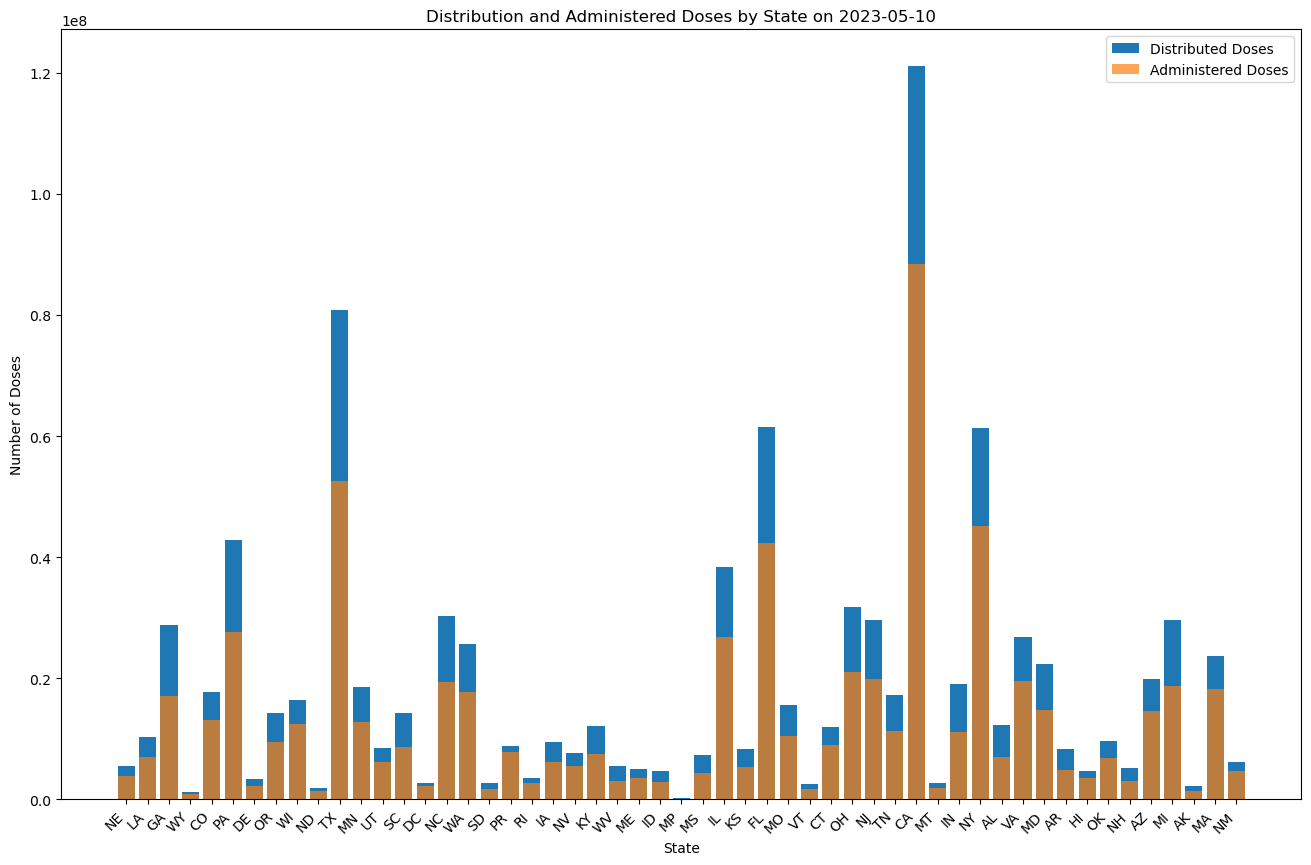

In [49]:
# Set the figure size
plt.figure(figsize=(16, 10))

# Plotting the distributed doses
plt.bar(dist_admin_doses_by_state_result['state'], dist_admin_doses_by_state_result['distributed'], label='Distributed Doses')

# Plotting the administered doses
plt.bar(dist_admin_doses_by_state_result['state'], dist_admin_doses_by_state_result['administered'], label='Administered Doses', alpha=0.7)

# Adding labels and title
plt.xlabel('State')
plt.ylabel('Number of Doses')
plt.title('Distribution and Administered Doses by State on 2023-05-10')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.show()

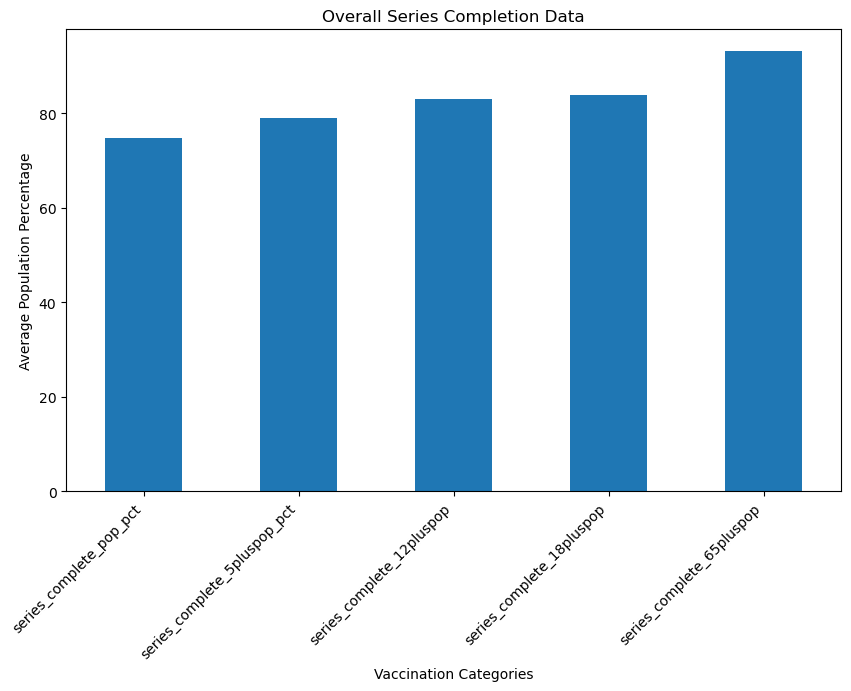

In [50]:
# Selecting relevant columns for visualization
selected_columns = ['series_complete_pop_pct', 'series_complete_5pluspop_pct',
                     'series_complete_12pluspop', 'series_complete_18pluspop',
                     'series_complete_65pluspop']

# Convert selected columns to numeric
series_comp_demograph_result[selected_columns] = series_comp_demograph_result[selected_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows with missing values
series_comp_demograph_result = series_comp_demograph_result.dropna(subset=selected_columns)

# Aggregate the data across all demographic categories 
overall_population_data = series_comp_demograph_result[selected_columns].mean()

# Create a DataFrame with aggregated data
overall_population_df = pd.DataFrame(overall_population_data, columns=['Population Percentage'])

# Plotting bar chart
ax = overall_population_df.plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Overall Series Completion Data')
plt.xlabel('Vaccination Categories')
plt.ylabel('Average Population Percentage')

# Rotate x-axis labels by 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()